# The neutron star matter EOS from $\chi$EFT 

### Authors: Alexandra Semposki

### Date last edited: 14 May 2024

#### [Adapted from: derivatives-bands.ipynb notebook in the BUQEYE nuclear-matter-convergence repository](https://github.com/buqeye/nuclear-matter-convergence/blob/master/analysis/derivatives-bands.ipynb)

This notebook reproduces the results from the paper _Quantifying uncertainties and correlations in the nuclear-matter equation of state_ by BUQEYE members Christian Drischler, Jordan Melendez, Dick Furnstahl, and Daniel Phillips (see [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805)), with order-by-order predictions of the pressure and speed of sound of symmetric nuclear matter (SNM) for $\Lambda = 500\,$MeV interactions.

This notebook uses modules from standard Python packages, third-party packages corner, gsum, and gptools, and the nuclear_matter package from BUQEYE, found [here](https://github.com/buqeye/nuclear-matter-convergence). The code from that repository was modified in the source file `derivatives_new.py`, where the extrapolation of the EOS from $\chi$EFT to $100n_{0}$ using the Prakash, Ainsworth, Lattimer (PAL) EOS was implemented. This is used for the pointwise Bayesian model mixing section of the present paper (Sec. III). 

---

This notebook also generates results for $E(n)/N$ (PNM) and the symmetry energy $E_{sym}$ from $\chi$EFT, and hence produces the necessary quantities used to obtain the EOS for neutron star matter (NSM), the calculation for which is also found here.

---

### Table of contents  ** under construction **

1. [Setting up the calculation](#setup)

## Setting up the calculation  <a id="setup"></a>

First, we need to import all of the required packages. The paths are set up such that the top directory is the GitHub repository that this notebook is contained in (EOS_BMM_SNM). If you have installed `gsum`, `gptools`, and `nuclear-matter-convergence` within the top directory, all of the paths here will work properly. 

Let's import all of our requirements below.

In [109]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Standard Python modules
import numpy as np
from scipy import stats
from scipy import interpolate
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
from os.path import join
import matplotlib.patches as mpatches
import pandas as pd
import time

# import source code
import sys
sys.path.append('../src')
sys.path.append('../data/NSM_data')

from chiral import Chiral

import corner  # https://corner.readthedocs.io/en/latest/

# To use gptools with Python 3, clone from GitHub repository 
#   https://github.com/markchil/gptools (development version)
# and install with 'pip install .' from inside repo. 
import gptools   # https://gptools.readthedocs.io/en/latest/

# accessing the cloned repo of nuclear-matter-convergence
sys.path.append('../nuclear-matter-convergence/')

# importing all necessary functions
from nuclear_matter import fermi_momentum, nuclear_density
from nuclear_matter import compute_pressure, compute_pressure_cov
from nuclear_matter import compute_slope, compute_slope_cov
from nuclear_matter import compute_compressibility, compute_compressibility_cov
from nuclear_matter import compute_speed_of_sound
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
from nuclear_matter import confidence_ellipse, confidence_ellipse_mean_cov
from nuclear_matter.graphs import add_top_order_legend, compute_filled_handles, plot_empirical_saturation
from nuclear_matter import lighten_color

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up the defaults for figures

The appearance of figures can be adjusted by changing `setup_rc_params` in `nuclear_matter` or by overriding those choices here. We also provide here all of the plotting functions used in this notebook that are not contained in the `nuclear_matter` scripts. 

In [110]:
setup_rc_params()

In [111]:
COLOR_68 = 'darkgrey'   # color for 1 sigma bands
COLOR_95 = 'lightgrey'  # color for 2 sigma bands

# sets the colors and styling of the curves and bands in the plots
def curve_plus_bands_plot(ax, x, y, std, color_68=None, color_95=None, 
                          zorder=None, edgecolor=None, **kwargs):
    """
    Plot y vs. x with one sigma and two sigma bands based on std on axis ax.
     Add any other keyword pairs to style the main curve.
    """
    ax.plot(x, y, zorder=zorder, **kwargs)
    if color_95 is not None:
        ax.fill_between(x, y + 2*std, y - 2*std, facecolor=color_95, 
                        edgecolor=edgecolor, zorder=zorder)
    if color_68 is not None:
        ax.fill_between(x, y + std, y - std, facecolor=color_68,
                        edgecolor=edgecolor, zorder=zorder, alpha=0.7)
    return ax

In [112]:
# adds either a rectangle or a vertical line 
# for where saturation density is located
def highlight_nsat(ax, nsat=0.164, zorder=0, band=False):
    ax.axvline(nsat, ls="--", lw=0.8, c='0.1', zorder=zorder)
    if band:
        import matplotlib.transforms as transforms
        trans = transforms.blended_transform_factory(
            ax.transData, ax.transAxes)
        n0_std = 0.007
        rect = mpatches.Rectangle(
            (nsat-n0_std, 0), width=2*n0_std, height=1,
            transform=trans, facecolor='0.85', edgecolor='0.6',
            linewidth=0.6,
            alpha=0.7, zorder=zorder-0.01
        )
        ax.add_patch(rect)

density_label = r'Density $n$ [fm$^{-3}$]'
kf_label = r'Fermi momentum $k_{F}$ [fm$^{-1}$]'

# plotter to plot with or without truncation error 
# from the truncation error calculations
def plot_with_and_without_truncation(
    density, y, std, std_with_trunc, density_data=None, y_data=None, add_nsat=True, axes=None, c=None, zorder=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3))
    ax1, ax2 = axes
    plot_obs_vs_density(
        density=density, y=y, std=std, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax1, c=c, zorder=zorder,
        **kwargs
    )
    plot_obs_vs_density(
        density=density, y=y, std=std_with_trunc, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax2, c=c, zorder=zorder,
        **kwargs
    )
    return axes

# handles plotting the order-by-order results for each physical
# quantity (E/A, P, cs2, etc.)
def plot_obs_vs_density(
    density, y, std, density_data=None, y_data=None, add_nsat=True, nsat_n0=False, ax=None, c='k',
    color_68=None, color_95=None, markersize=3, edgecolor=None, zorder=0, wrt_kf=False,
    **kwargs
):
    if wrt_kf is True:
        kf = fermi_momentum(density,4)
    if ax is None:
        fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3), dpi=600) 
    curve_plus_bands_plot(
        ax, density, y, std, c=c, color_68=color_68, color_95=color_95,
        edgecolor=edgecolor, zorder=zorder, **kwargs
    )
    ax.set_xlabel(density_label)
    ax.margins(x=0)
    
    if y_data is not None:
        c_marker = c if c is not None else 'k'
        ax.plot(
            density_data, y_data, ls='', marker='o', c=c_marker, markersize=markersize,
            zorder=zorder, **kwargs
        )
        ax.plot(
            density_data, y_data, ls='', marker='o', c=c_marker, markersize=markersize,
            zorder=zorder, **kwargs
        )
    if add_nsat is True and nsat_n0 is True:
        highlight_nsat(ax, nsat=1.0, zorder=zorder)
    elif add_nsat:
        highlight_nsat(ax, zorder=zorder)

    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    return ax

# plotter to handle the panelling of each figure for order-by-order plotting
def plot_obs_panels(density, y, dy, orders, density_data=None, y_data=None, colors=None, axes=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(2, 2, figsize=(5, 5), dpi=600) 
    fig = plt.gcf()
    fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.2/72)
    
    if colors is None:
        color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
        cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
        colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
    
    light_colors = [lighten_color(color) for color in colors]
    dark_colors = [lighten_color(color, 1.5) for color in colors]

    for j, ax in enumerate(axes.ravel()):
        for i, n in enumerate(orders[:j+1]): 
            if y_data is not None:
                y_data_i = y_data[:, i]
            else:
                y_data_i = None

            plot_obs_vs_density(
                density,
                y[:, i],
                dy[:, i],
                ax=ax,
                c=colors[i],
                color_68=light_colors[i],
                edgecolor=colors[i], 
                add_nsat=i==j, 
                zorder=i/3,
                density_data=density_data,
                y_data=y_data_i,
                markersize=3,
                **kwargs
            )
        ax.axhline(0, 0, 1, c='k', lw=0.8)
        ax.xaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(right=True, top=True, which='both') # stop for loop after line
    add_top_order_legend(fig, axes[0, 0], axes[0, 1], order_labels, colors, light_colors, dark_colors)
    axes[0,0].set_xlabel('')
    axes[0,1].set_xlabel('')
    return fig, axes

## Standard Case

We have data and would like to find a function that best captures the relationship between the inputs and outputs.
A popular nonparametric tool for regression is a Gaussian process (GP).
One of the neat things about a GP is that you automatically get uncertainty quantification along with the line of best fit.
But what is less well known is that it also provides derivatives of the best fit line, and corresponding uncertainty estimates, for free!

The derivative is a linear operator, so the distributions for derivatives follow similarly to how one transforms a Gaussian random variable by scalars or matrices.
Suppose $f$ is distributed as a ($n$-dimensional, for genalizability) Gaussian random variable,
\begin{align}
    f \sim N(0, \Sigma).
\end{align}
Then for some $N\times n$ matrix $C = [1, D]^T$,
\begin{align}
    C f = \begin{bmatrix} 1 \\ D \end{bmatrix} f
    \sim N(0, C \Sigma C^T)
\end{align}
Suppose now that $D = d/dx$ and $f$ is some function of $x$, distributed as a Gaussian process:
\begin{align}
    f(x) \sim GP[0, \kappa(x, x')].
\end{align}
The above logic allows us to find how $f$ correlates with its derivative:
\begin{align}
    \begin{bmatrix} f(x) \\ f'(x) \end{bmatrix}
    & \sim GP[0, K(x, x')] \\
    K(x, x') & =
    \begin{bmatrix}
        K_{00}(x, x') & K_{01}(x, x') \\
        K_{10}(x, x') & K_{11}(x, x')
    \end{bmatrix} =
    \begin{bmatrix}
        \kappa(x, x') & \frac{d}{dx'}\kappa(x, x') \\
        \frac{d}{dx}\kappa(x, x') & \frac{d^2}{dxdx'}\kappa(x, x')
    \end{bmatrix}
\end{align}
It will be useful later to know how to add a function with its derivative, while propagating uncertainties.
For this, we will need
\begin{align}
    Af + Bf' \sim GP[0, AK_{00}A^T + BK_{11}B^T + AK_{01}B^T + BK_{10}A^T]
\end{align}



In [113]:
def draw_func_and_derivative(Xstar, kernel, X=None, y=None, err_y=None, draws=1, extra_kernel=None):
    n = Xstar.shape[0]
    XsXs = np.concatenate((Xstar, Xstar), axis=0)
    derivs = np.concatenate((np.zeros(Xstar.shape), np.ones(Xstar.shape)), axis=0)

    gp = GaussianProcess(k=kernel)
    if X is not None and y is not None:
        gp.add_data(X, y, err_y=err_y)
        gp.optimize_hyperparameters(max_tries=10)
        mean, K = gp.predict(XsXs, n=derivs, return_cov=True)
    else:
        K = gp.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)
        mean = np.zeros(2*n)
        
    if extra_kernel is not None:  # We will use this for the truncation error later
        gp_extra = GaussianProcess(k=extra_kernel)
        K += gp_extra.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)

    # The draw_sample function is much more numerically stable than
    # just using stats.multivariate_normal
    # Since we pass mean and cov, the first arguments aren't used.
    samples = gp.draw_sample(XsXs, derivs, mean=mean, cov=K, num_samp=draws)  # shape = (2n, draws)
    return samples.reshape(2, n, draws)  # separate f and f_prime by first dimension

# Nuclear Matter Application <a id="nuclear_matter"></a>

Our specific use case: we fit a GP to data, in this case from a physics simulation, and incorporate theory error from custom kernel design (see `derivatives.py` for the original source code from the BUQEYE group).

## Import the data <a id="import_data"></a>

Choices to make here:
* Select $\Lambda = 450$ or $500\,$MeV interactions with `Lambda`. (See [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805) for details.)
* Select low or high density data by setting `high_density` to `False` or `True`.

The calculated nuclear matter data for input is in the `data` directory in csv files.

In [114]:
# choose density range and initialize the class to run the source code
density_input = np.linspace(0.05, 0.4, 600) 
#density_input = np.linspace(0.05,16.4,600)
chiral = Chiral(density_input=density_input, Lambda = 500, high_density=True)

# set the density from the class
density_all = chiral.density_all
len(density_all) # should show number of chosen points

600

In [115]:
# class variables checker (should read 600 MeV if all is well)
chiral.breakdown

600

Visualize the EOS. The data below comes from fourth-order MBPT calculations (see [arXiv:2004.07805](https://arxiv.org/abs/2004.07805), [arXiv:1710.08220](https://arxiv.org/abs/1710.08220) for details).

In [116]:
# some definitions for plotting
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# set plot order labels
order_labels = ['LO', 'NLO', 'N$^{2}$LO', 'N$^{3}$LO']

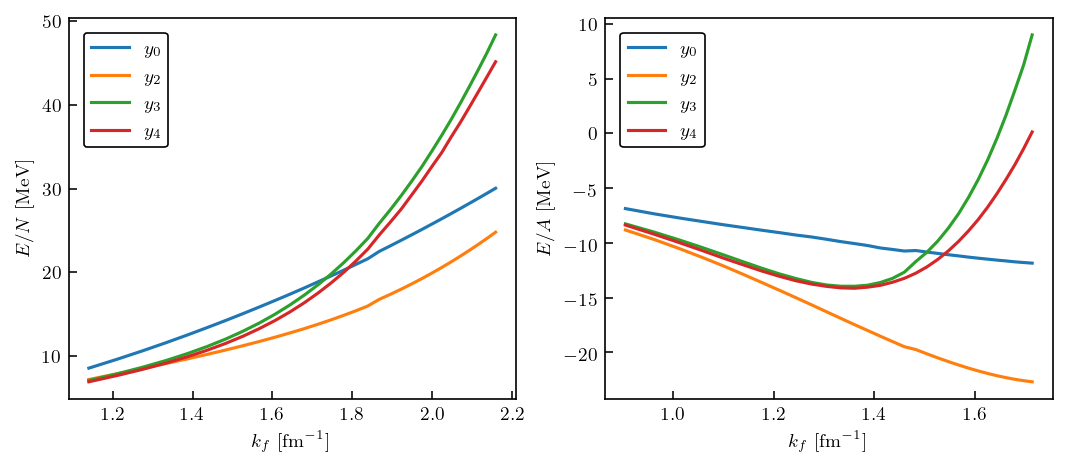

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
# fig.tight_layout(pad=2.5) 

# first neutron matter
for i, n in enumerate(chiral.orders):
    ax[0].plot(chiral.kf_n, chiral.y_n_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[0].legend()
ax[0].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[0].set_ylabel(r'$E/N$ [MeV]');

# then symmetric matter
for i, n in enumerate(chiral.orders):
    ax[1].plot(chiral.kf_s, chiral.y_s_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[1].legend()
ax[1].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[1].set_ylabel(r'$E/A$ [MeV]');

Begin by interpolating the data points we plotted above. This does not include truncation error yet. Also compute its derivative as before.

In [118]:
# call the containers for PNM, SNM, and symmetry energy 
# from the modified source code
from derivatives_new import ObservableContainer, SymmetryEnergyContainer

# set to True to see the results as they are output
verbose = True

# set up the containers and run the interpolation
# if running farther than 0.34 fm^-3, select extend=True to use PAL EOS
obs_neutron, obs_nuclear, obs_sym_energy = \
chiral.data_interpolation(density_int=None, kf_s_int=None, extend=False)

Setting up neutron matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8
Setting up nuclear matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 6
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 7
Setting up symmetry energy...
0.973 0.484 0.8119689713375328
For EFT order 0, the best polynomial has max nu = 7
For EFT order 2, the best polynomial has max nu = 7
For EFT order 3, the best polynomial has max nu = 7
For EFT order 4, the best polynomial has max nu = 7
Setup time: 82.41163516044617


The values of $\nu$ above correspond to the highest order to which one should fit, based on the interpolation, a functional

\begin{align}
    \sum_{\nu = 2}^M c_\nu \left(\frac{n}{n_0}\right)^{\nu/3},
\end{align}

which can be used to attempt to interpolate the MBPT results for energy per particle. However, because finite differences used here fail, especially when one considers the second derivative, we use instead our GPs to construct the means and truncation errors of the data.

Now we will continue on and look at the truncation error calculation we get when using `gsum` and `gptools` to perform uncertainty quantification on the energy per particle for SNM.

In [119]:
# convert array from density to kf
d = density_all
kf = (3.0 * np.pi**2.0 * d/2.0)**(1.0/3.0)

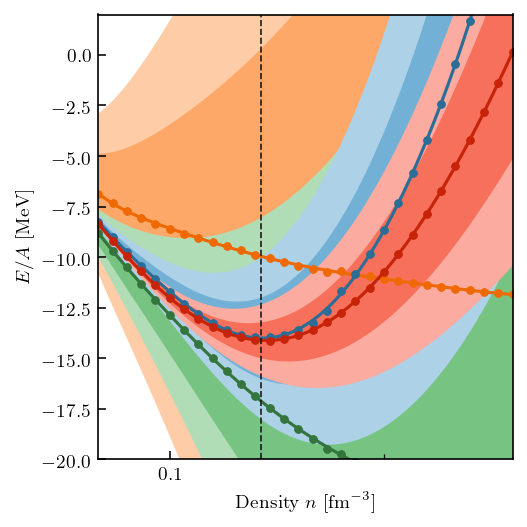

In [120]:
# plotting the E/A result with truncation errors now (get_pred, get_std functions below)
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=True),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True), 
        # just proof of finite difference failing, if deriv>=2
        wrt_kf=True,
    )
    
ax.set_xticks([0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9])#, 2.2, 2.5, 2.8, 3.1])
ax.set_ylim(-20, 2.0)
ax.set_xlim(0.05,.34)
ax.set_ylabel(r'$E/A$ [MeV]');

# calculate Q wrt kf instead of n 
hbarc = 197.327 
kf_cutoff = 600/hbarc

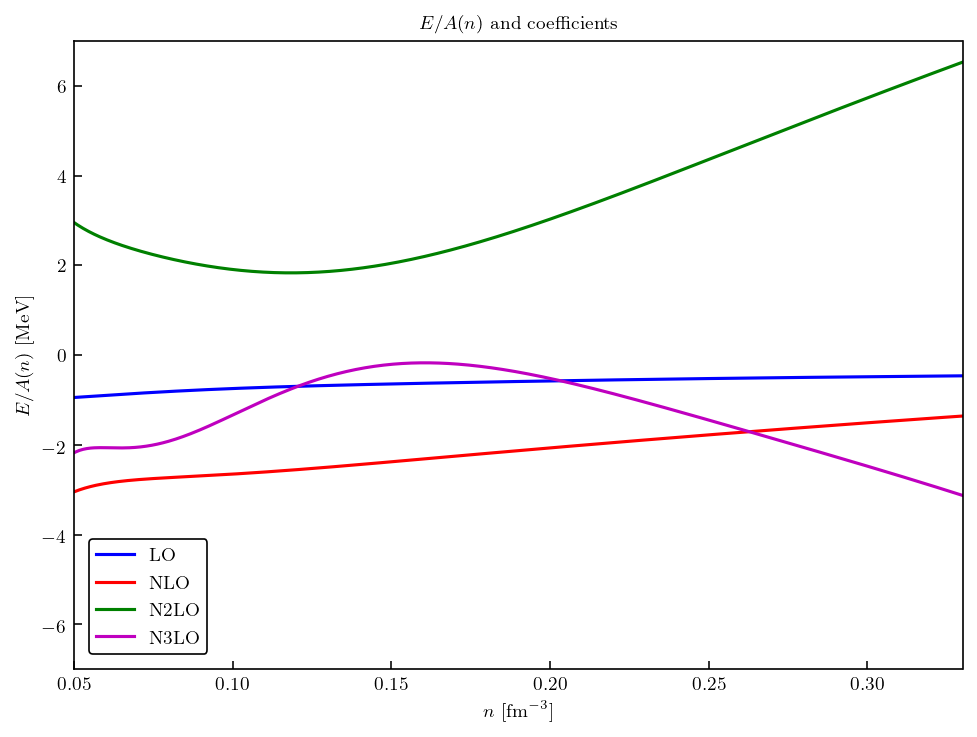

In [121]:
# plotting the coefficients of the series expansion for SNM
# this is using the y(x) formalism of gsum
epp = [obs_nuclear.get_pred(order=n, deriv=0) for n in chiral.orders]

hbarc = 197.327 # MeV fm

# we want to see if the coefficients at each order are naturally sized
kf_s = hbarc * (3.0 * np.pi**2.0 * chiral.density_all/2.0)**(1.0/3.0)  #[MeV]
kf_0 = hbarc * (3.0 * np.pi**2.0 * 0.164/2.0)**(1.0/3.0)    # [MeV]
yref_n = 16.0 * (kf_s/kf_0)**(2.0)    # [MeV]

# try dividing by yref here (simple test for mean results)
LO_coeff = epp[0]/yref_n

# Q
exp_Q = (kf_s/chiral.breakdown)   # [dimensionless]

# second one (now mindful of Q)
NLO_coeff = ((epp[1]/yref_n) - LO_coeff)/(exp_Q)**2.0

# third one (N2LO)
N2LO_coeff = ((epp[2]/yref_n) - NLO_coeff*(exp_Q)**2.0 - LO_coeff)/(exp_Q)**3.0

# fourth one (N3LO)
N3LO_coeff = ((epp[3]/yref_n) - N2LO_coeff*(exp_Q)**3.0 - NLO_coeff*(exp_Q)**2.0 - LO_coeff)/(exp_Q)**4.0

plt.xlim(0.05, 0.33)
plt.ylim(-7,7)
plt.xlabel(r'$n$ [fm$^{-3}$]')
plt.ylabel(r'$E/A(n)$ [MeV]')
plt.title(r'$E/A(n)$ and coefficients')
plt.plot(chiral.density_all, LO_coeff, 'b', label='LO')
plt.plot(chiral.density_all, NLO_coeff, 'r', label='NLO')
plt.plot(chiral.density_all, N2LO_coeff, 'g', label='N2LO')
plt.plot(chiral.density_all, N3LO_coeff, 'm', label='N3LO')
plt.legend(loc='lower left')
plt.show()

Now that we have a handle on the EFT itself, we will move to the truncation errors. For each order, they should be on the order of the next power. We've already plotted the E/A result with truncation error, but now let's look at if we only use truncation error, if we only use interpolation error from the GP, and if we combine them together (as is done in the final result for the truncation error bands).

Using only truncation error:


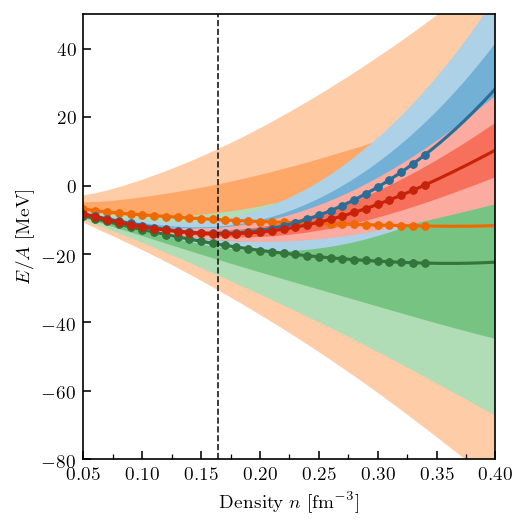

Using only interpolation error:


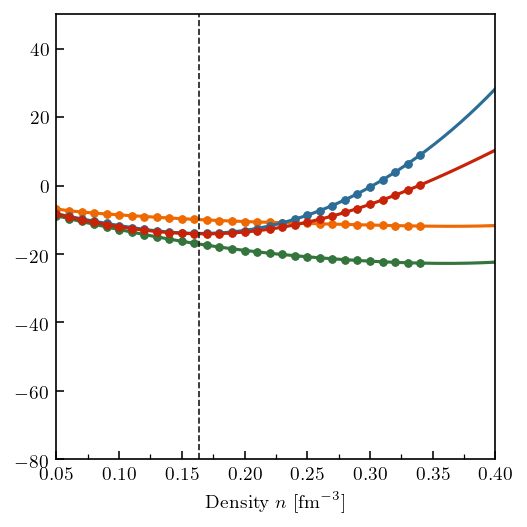

Using both truncation and interpolation error:


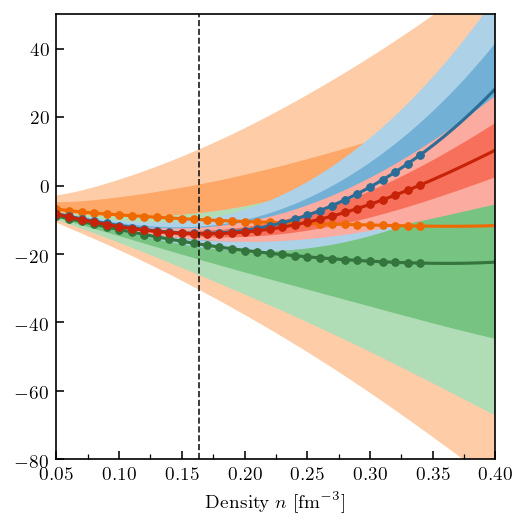

In [122]:
# look at the truncation error bands now at each order and test their scaling
trunc_std = np.zeros([len(chiral.density_all), len(chiral.orders)]).T
for i, n in enumerate(chiral.orders):
    trunc_std[i] = obs_nuclear.get_trunc_std(order=n, deriv=0)

# now take this and plot it 
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
ax.set_ylim(-80.0, 50.0)

print('Using only truncation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_trunc_std(order=n, deriv=0),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
ax.set_ylabel(r'$E/A$ [MeV]');
plt.show()

# now only plot the interpolation GP errors
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
ax.set_ylim(-80.0, 50.0)
print('Using only interpolation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=False),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
plt.show()

# now plot both
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
ax.set_ylim(-80.0, 50.0)
print('Using both truncation and interpolation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=True),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
plt.show()

We see that, at this point in density, there is very little GP interpolation error---which makes sense, since we are within the range of our data. If we were to increase the density range out farther, we would see this quantity increase, since we will be outside of our data range and the GP will resort to extrapolation.

---

## Make Order-by-Order Predictions with Uncertainties for NSM <a id="order_by_order"></a>

In the usual case, we would need to worry about these GPs being calculated in the space of Fermi momentum. However, because we are choosing to ignore the correlations in density and derivatives, which turns out to be an adequate approximation for the current application, we will not need to worry about this. Instead, we will take the means and variances from PNM and SNM data, calculated below, to construct the NSM EOS.

In [123]:
from nuclear_matter import kf_derivative_wrt_density

[2.95  0.484]


/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


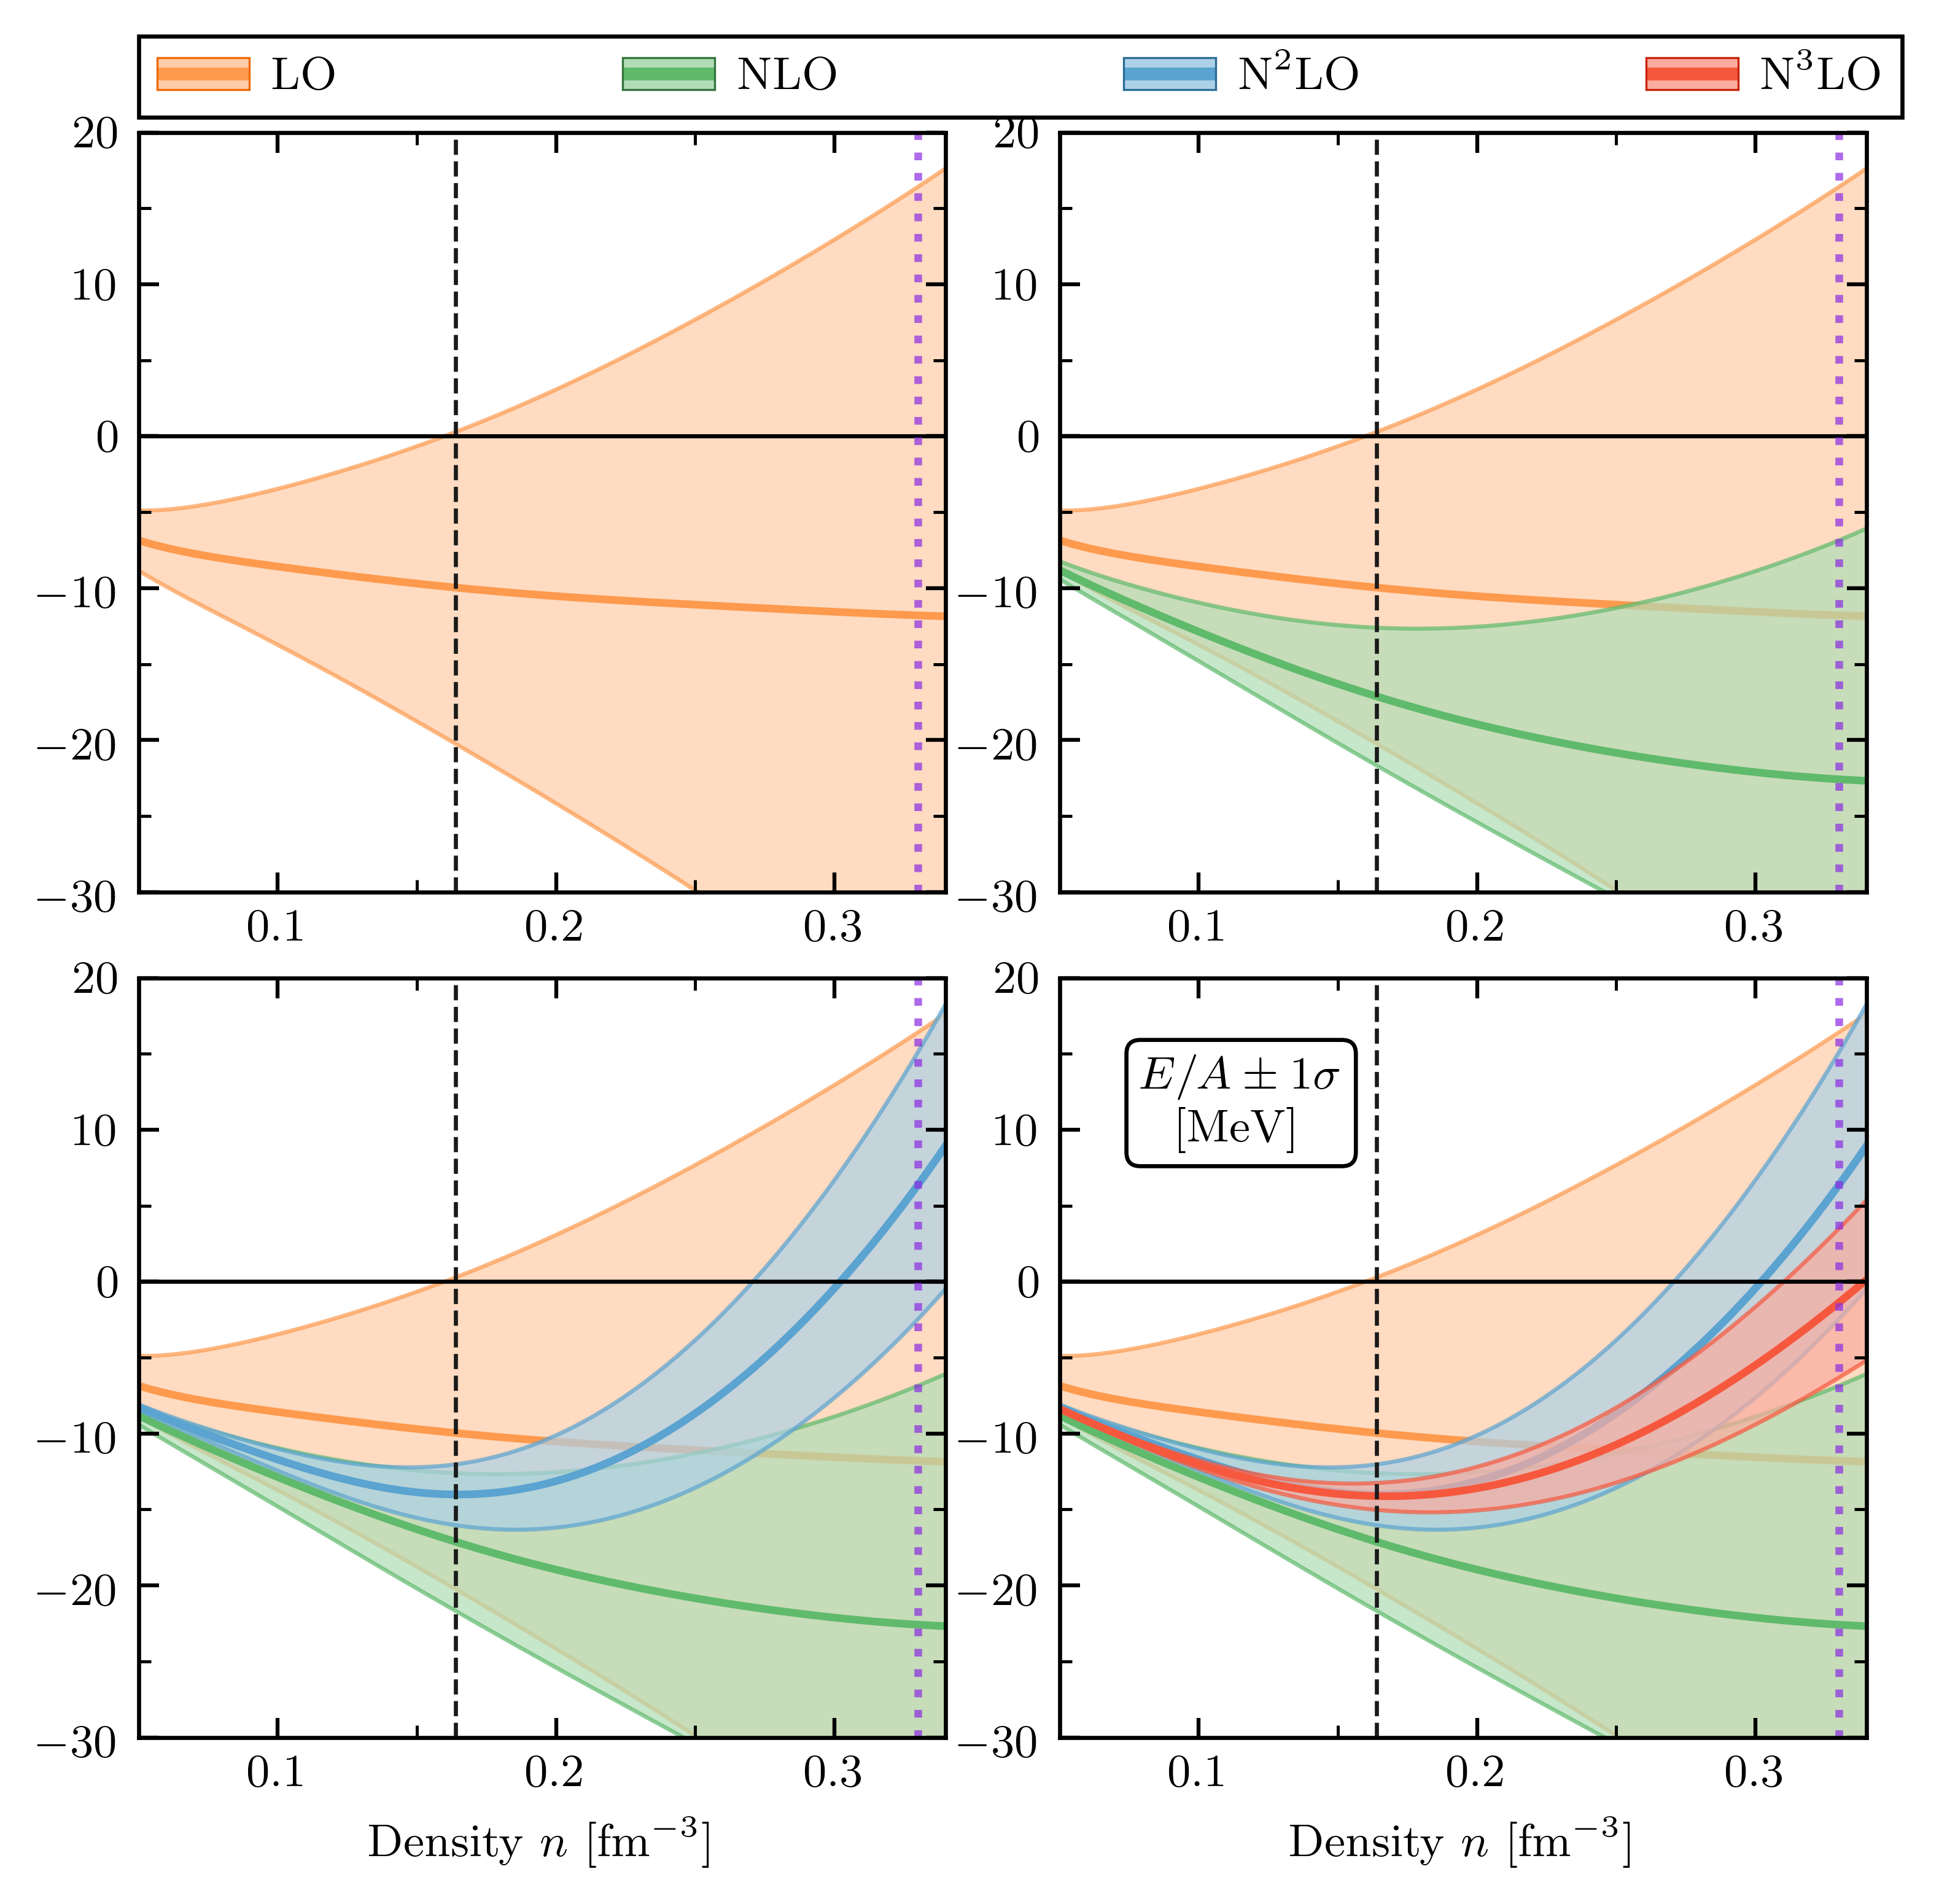

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


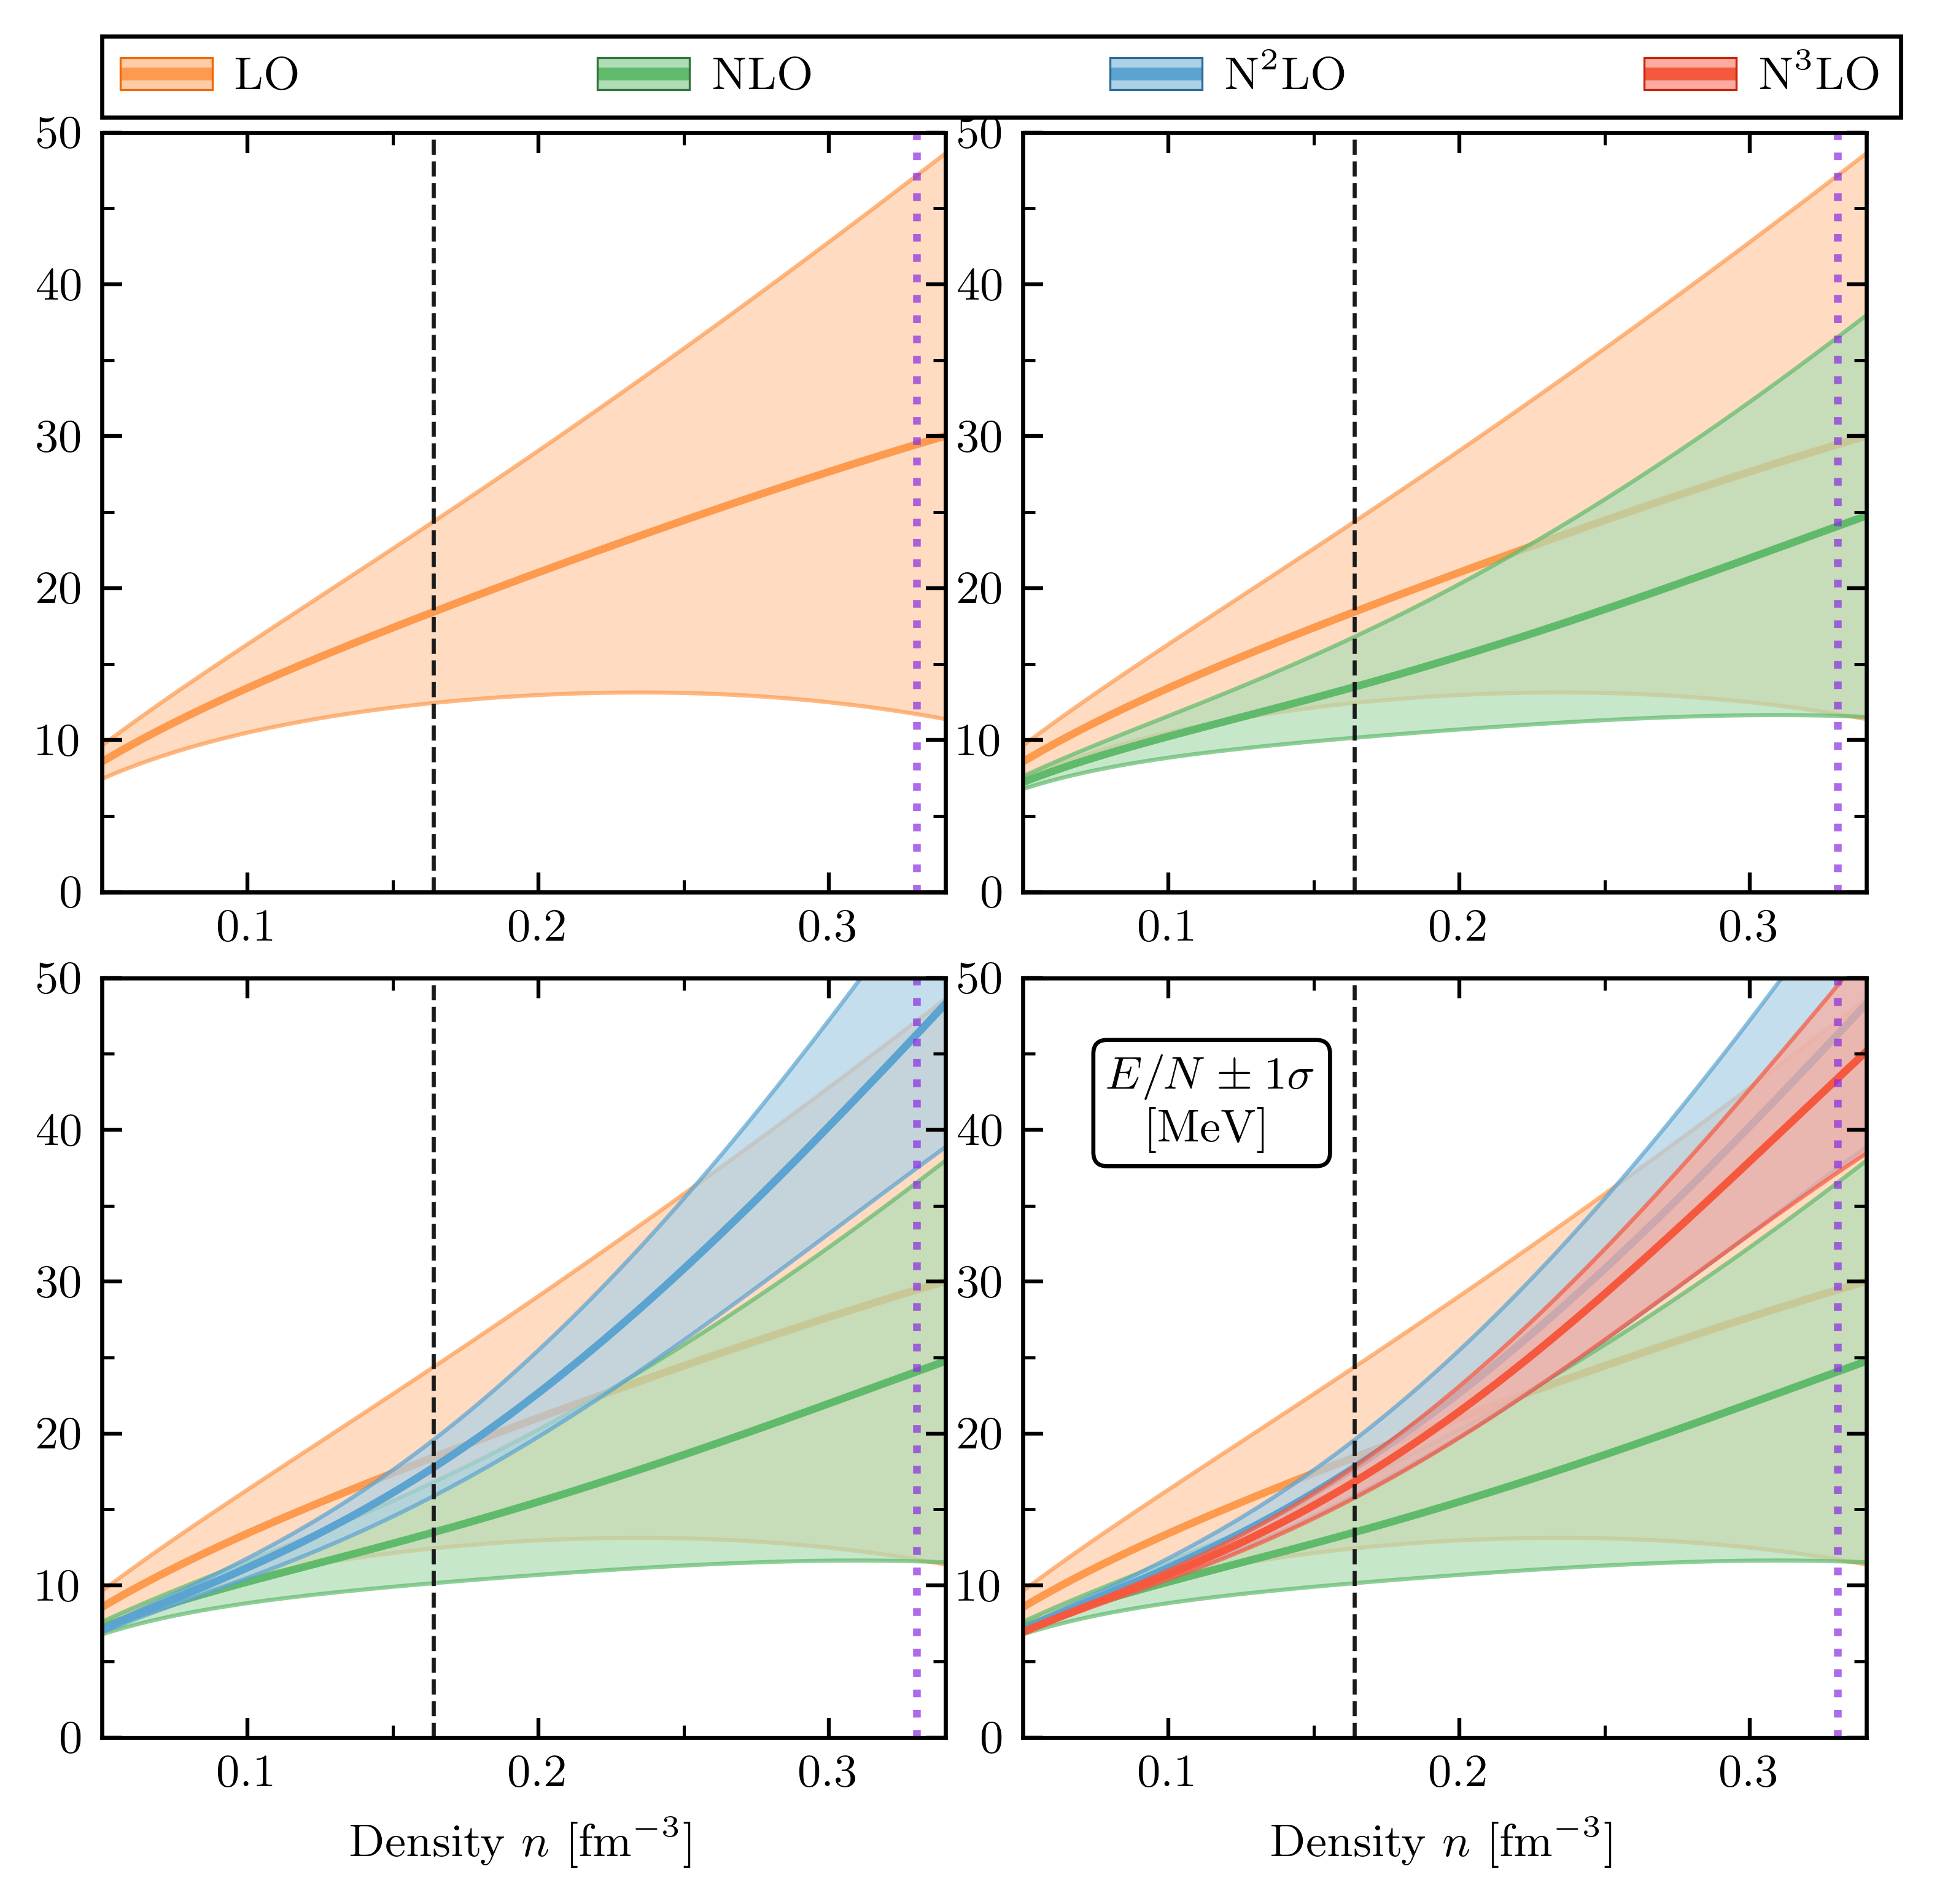

In [124]:
# E/A result for SNM
energies_s_mn, energy_s_stds = chiral.energy_per_particle(add_rest_mass=False, case='SNM')

print(chiral.obs_nuclear.coeff_kernel.params)

fig, axes = plot_obs_panels(
    density_all, y=energies_s_mn, dy=energy_s_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(-30, 20)
axes[1, 0].set_ylim(-30, 20)
axes[1, 1].set_ylim(-30, 20)
axes[0, 1].set_ylim(-30, 20)
for ax in axes.reshape(-1):
    ax.set_xlim(0.05, 0.34)
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)

label = r"""$E/A \pm 1\sigma$
[MeV]""" 
ax.text( 
    0.1, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

# E/N result for PNM
energies_n_mn, energy_n_stds = chiral.energy_per_particle(add_rest_mass=False, case='PNM')

fig, axes = plot_obs_panels(
    density_all, y=energies_n_mn, dy=energy_n_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(0, 50)
axes[1, 0].set_ylim(0, 50)
axes[1, 1].set_ylim(0, 50)
axes[0, 1].set_ylim(0, 50)
for ax in axes.reshape(-1):
    ax.set_xlim(0.05, 0.34)
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)

label = r"""$E/N \pm 1\sigma$
[MeV]""" 
ax.text( 
    0.1, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

# plot the symmetry energy (if we can)
# plt.plot(density_all, obs_sym_energy.get_pred(order=2, deriv=0), color=colors[0])
# plt.plot(density_all, obs_sym_energy.get_pred(order=3, deriv=0), color=colors[2])

### Symmetry energy and full covariance matrix for PNM, SNM

In [125]:
# first we import the routines we will need to create the matrices
from nuclear_matter.stats_utils import create_sym_energy_truncation_covariance,\
create_truncation_multi_covariance, create_truncation_cross_covariance, create_rbf_cross_covariance

In [126]:
# run the symmetry energy calculation
cbar_n = 1.0013486060408017 
ls_n = 0.9731398181235965
cbar_s = 2.947690541619698 
ls_s = 0.4846364734101806

kf_conversion_factor = 2 ** (1/3.)
ls_s_scaled = kf_conversion_factor * ls_s

# conditions for Lambda = 500
rho_sym_energy = None
rho_corr = np.sqrt(2 * ls_n * ls_s_scaled / (ls_n**2 + ls_s_scaled**2))
ls1 = ls_n
ls2 = ls_s_scaled

print('rho', rho_corr, rho_sym_energy)

# reference scales used in the paper (generate here)
from functools import partial
from nuclear_matter.stats_utils import *
from nuclear_matter.matter import *

# calculate the needed Fermi momentum arrays
kf_n = fermi_momentum(density_all, degeneracy=2)
Kf_n = kf_n[:,None]
kf_s = fermi_momentum(density_all, degeneracy=4)
Kf_s = kf_s[:,None]

kf0_n = chiral.kf0_n
kf0_s = chiral.kf0_s

def ref_quadratic(X, scale=1):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * (X.ravel() / scale) ** 2

ref_2bf_func_n = partial(ref_quadratic, scale=kf0_n)
ref_2bf_func_s = partial(ref_quadratic, scale=kf0_s)

rho 0.9489034438537537 None


In [138]:
# now we need to run the actual covariance generation
std_d_truncs = {}
cov_truncs = {}
for i, n in enumerate(chiral.orders):
    kmin = n+1 if n != 0 else 2
    
    # used to get the truncation error bands below (see the figure)
    K_d_cov, K_d_trunc = create_sym_energy_truncation_covariance(
        density_all, cbar_n, cbar_s, ls1, ls2,
        ref_2bf_func_n(Kf_n), ref_2bf_func_s(Kf_s),
        ratio_kf(Kf_n, breakdown=chiral.breakdown), ratio_kf(Kf_s, breakdown=chiral.breakdown),
        kmin=kmin, nugget=1e-10, rho=rho_sym_energy
    )
    cov_d_trunc = K_d_cov
    std_d_trunc = np.sqrt(np.diag(K_d_trunc))
    cov_truncs[n] = cov_d_trunc
    std_d_truncs[n] = std_d_trunc
    
# print the shape
print(K_d_trunc.shape)

# separate out the order we want from the std_dev
std_d_trunc_n3lo = std_d_truncs[4]

(600, 600)


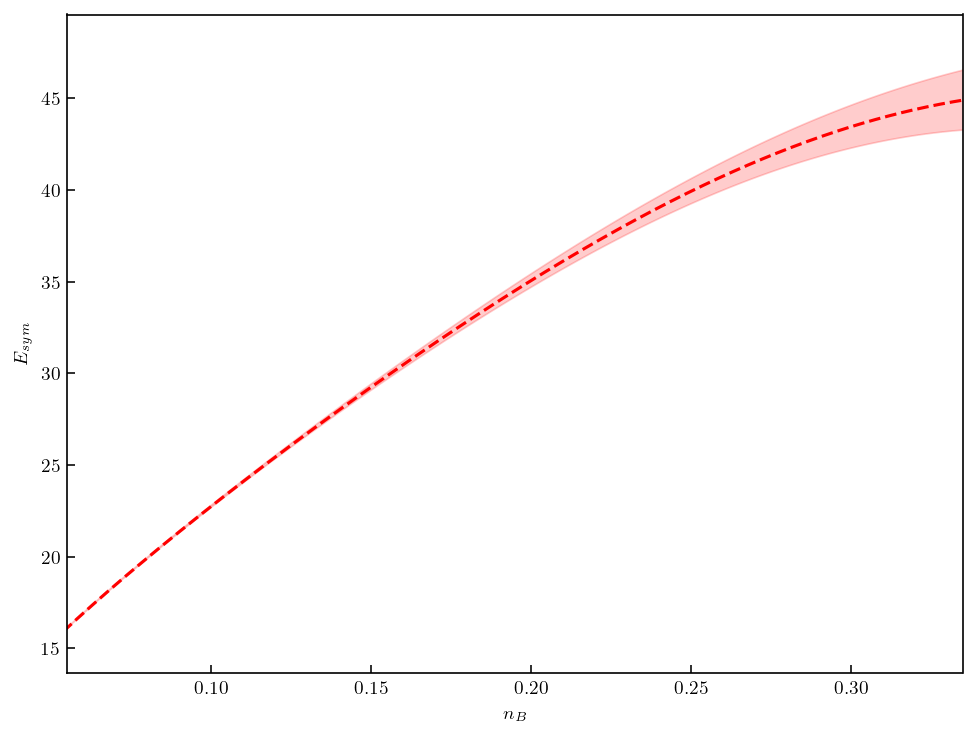

In [139]:
# now we can plot the symmetry energy if we so desire, in N3LO
e_sym = energy_n - energy_s 
plt.plot(density_all, e_sym, 'r', linestyle='dashed')
#plt.fill_between(density_all, p_NSM_N2LO_lower, p_NSM_N2LO_upper, alpha=0.3, color='k')
plt.fill_between(density_all, e_sym-std_d_trunc_n3lo, e_sym+std_d_trunc_n3lo, alpha=0.2, color='r')
plt.xlabel(r'$n_{B}$')
plt.ylabel(r'$E_{sym}$')
# plt.ylim(0.0, 1.0)
# plt.xlim(0.05, 0.1)
plt.xlim(min(n3lo_nsm_mean[:,2]), max(n3lo_nsm_mean[:,2]))
plt.show()

### Constructing $E_{NSM}(n_{B})$

All right, we've our E(n)/A and E(n)/N results for SNM and PNM, respectively. Now we want to combine these into the NSM EOS, perform error propagation, and numerically differentiate to obtain the P(n) result. 

To properly do this, we will also need to use the conditions of beta equilibrium, which will help us to determine the proton fraction at each baryon number density, $n_{B}$.

Our equations are

$$
E_{NSM} = E_{PNM}(1-2x)^{2} + E_{SNM}4x(1-x) + E_{e} + E_{\mu},
$$

where we can determine $E_{e}$ and $E_{\mu}$ to be 

$$
\mu_{e} \equiv \mu_{\mu} = 4E_{sym}(1-2x),
$$

and where

$$
E_{sym} = E_{PNM} - E_{SNM}.
$$

We also define $x$ as the proton fraction, which can be expressed in terms of the baryon number density as $x = n_{p}/n_{B}$.

Hence, we can propagate error and only have dependence on the two quantities we just calculated above. We invoke beta equilibrium by solving simulataneously the condition

$$
\frac{\partial E_{NSM}}{\partial x} = 0.
$$

Because our variable is the baryon number density, $n_{B}$, we need to make sure that this fact is not eliminated from the problem. 

In [140]:
# Algorithm for following code

# 1) Define the function for E_NSM in terms of each nB value (one run)
# 2) Take the partial derivative of E_NSM wrt x 
# 3) Minimize this quantity to obtain x  --- > or do this another way?
# 4) Construct E_NSM from everything above

In [141]:
# load in the data sets from Christian for comparison

#N3LO (only one we're using)
n3lo_nsm_mean = np.loadtxt('../data/NSM_data/EoS_NSM_N3L0_cen.dat', skiprows=1)
n3lo_nsm_lower = np.loadtxt('../data/NSM_data/EoS_NSM_N3L0_mns.dat', skiprows=1)
n3lo_nsm_upper = np.loadtxt('../data/NSM_data/EoS_NSM_N3L0_pls.dat', skiprows=1)

# N2LO
n2lo_nsm_mean = np.loadtxt('../data/NSM_data/EoS_NSM_N2L0_cen.dat', skiprows=1)
n2lo_nsm_lower = np.loadtxt('../data/NSM_data/EoS_NSM_N2L0_mns.dat', skiprows=1)
n2lo_nsm_upper = np.loadtxt('../data/NSM_data/EoS_NSM_N2L0_pls.dat', skiprows=1)

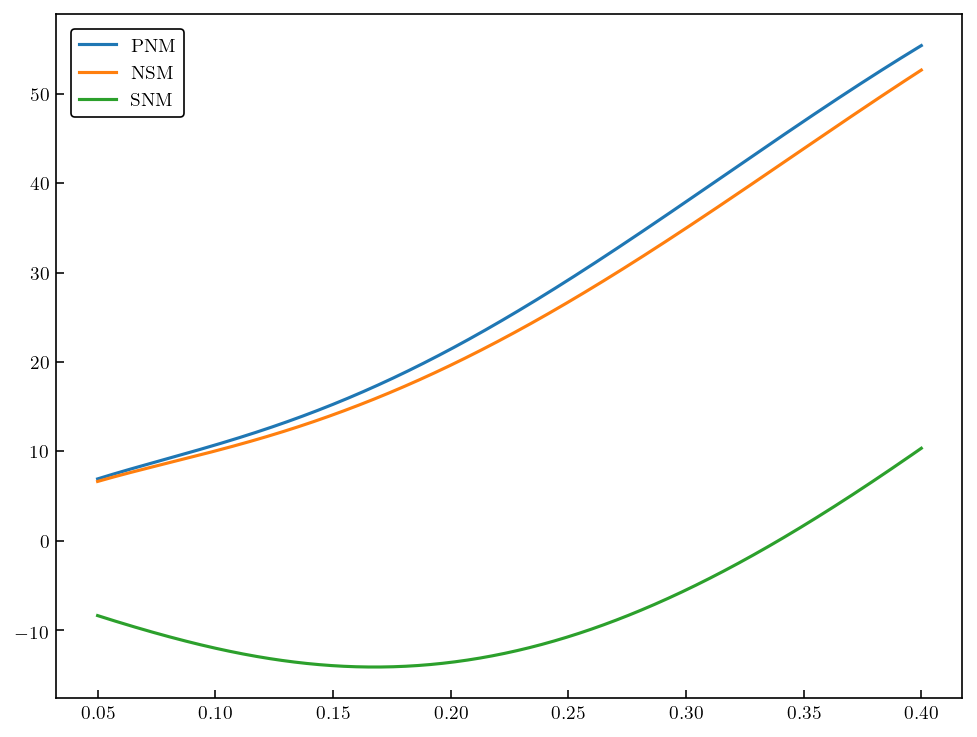

In [142]:
# routine to calculate NSM

import numdifftools as ndt
from scipy.optimize import fsolve, root

hbarc = 197.327    # [MeV fm]
mu_mass = 105.65837 / hbarc  # [fm^-1]
mass_p = 938.272 / hbarc     # [fm^-1]
mass_n = 939.565 / hbarc     # [fm^-1]

# first define the energies from PNM and SNM as only one order
energy_n = energies_n_mn[:,3]  # MeV
energy_s = energies_s_mn[:,3]  # MeV

# define the proton fraction routine
def proton_fraction(x_guess, nB, energy_n, energy_s, xtol=1e-8):
    
    # if muons, occur, include them (root version)
    def no_muons(x_guess, *args):
        nB = args
        mu = 4.0 * (1.0 - 2.0 * x_guess) * (energy_n - energy_s) / hbarc  # [fm^-1]
        return -x_guess * nB + mu**3.0/(3.0*np.pi**2.0)
    
    def with_muons(x_guess, *args):
        nB = args
        mu = 4.0 * (1.0 - 2.0 * x_guess) * (energy_n - energy_s) / hbarc  # [fm^-1]
        return (-x_guess * nB + mu**3.0/(3.0*np.pi**2.0) +\
                np.sqrt(mu**2.0 - mu_mass**2.0)**(3.0)/(3.0*np.pi**2.0))
        
    sol = root(no_muons, x_guess, args=(nB), method='hybr', tol=xtol)
    mu = 4.0 * (1.0 - 2.0 * sol.x) * (energy_n - energy_s) / hbarc
    
    if mu > mu_mass:
        sol = root(with_muons, x_guess, args=(nB), method='hybr', tol=xtol)

#     if mu < mu_mass:
#         sol = root(no_muons, [x], args=(nB), method='hybr', tol=xtol)
#     else:
#         sol = root(with_muons, [x], args=(nB), method='hybr', tol=xtol)
                           
    return sol.x

def edens_lepton(k, m, en):

    pre = 1.0 / (4.0 * np.pi**2.0)
    one = en * k                          #[fm^-2]
    two = (k**2.0 + 0.50 * m**2.0)     #[fm^-2]
    three = 0.50 * m**4.0               #[fm^-4]
    four = np.log((k + en) / m)            

    # calculate and return energy density
    eps = pre * (one * two - three * four)    #[fm^-4]

    return eps

# make arrays for quantities to keep
x = np.zeros_like(density_all)
xmu = np.zeros_like(density_all)
xe = np.zeros_like(density_all)
e_NSM_B = np.zeros_like(density_all)
e_NSM_e = np.zeros_like(density_all)
e_NSM_mu = np.zeros_like(density_all)
mumu = np.zeros_like(density_all)
mue = np.zeros_like(density_all)
eps_e = np.zeros_like(density_all)
eps_mu = np.zeros_like(density_all)
eps_B = np.zeros_like(density_all)
eps_NSM = np.zeros_like(density_all)
kfmu = np.zeros_like(density_all)
enmu = np.zeros_like(density_all)
e_NSM = np.zeros_like(density_all)

# start with one order, see how it goes (not well apparently...)
for i in range(len(density_all)):
   
    # define guess for proton fraction (iteratively solve)
    if i == 0:
        x_guess = 0.05 #0.1 for N2LO, 0.05 for N3LO
    else:
        x_guess = x[i-1]
    
    # call solver
    x[i] = proton_fraction(x_guess, density_all[i], energy_n[i], energy_s[i], xtol=1e-12)
    
    # calculate mu chemical potential (for use in lepton energy)
    mumu[i] = 4.0 * (1.0 - 2.0 * x[i]) * (energy_n[i] - energy_s[i]) / hbarc   # [fm^-1]
            
    # baryon energy part
    e_NSM_B[i] = energy_n[i] * (1.0 - 2.0 * x[i])**2.0 + energy_s[i] * 4.0 * x[i] * (1.0 - x[i])
    
    # baryon energy density
    eps_B[i] = (e_NSM_B[i] + hbarc * ((mass_n + mass_p)/2.0)) * density_all[i]
    
    # electron
    mue[i] = 4.0 * (1.0 - 2.0 * x[i]) * (energy_n[i] - energy_s[i]) / hbarc    # [fm^-1]
    xe[i] = mue[i]**(3.0) / (3.0 * np.pi**2.0 * density_all[i])  
    eps_e[i] = hbarc * mue[i]**4.0 / (4.0 * np.pi**2.0)  # [MeV/fm^3]
    e_NSM_e[i] = eps_e[i] / density_all[i]  # MeV
        
    # muons (only occur for condition below!)
    e_NSM_mu[i] = 0.0
    eps_mu[i] = 0.0
    xmu[i] = 0.0
    
    # if muons, add to energy density and total energy
    if mumu[i] > mu_mass:  
#         kfmu[i] = np.sqrt(mumu[i]**2.0 - mu_mass**2.0)
#         enmu[i] = np.sqrt(kfmu[i]**2.0 + mu_mass**2.0)
        xmu[i] = x[i] - xe[i] #kfmu[i]**3.0 / (3.0 * np.pi**2.0 * density_all[i])
        kfmu[i] = (3.0 * np.pi**2.0 * xmu[i] * density_all[i])**(1.0/3.0)
        enmu[i] = np.sqrt(kfmu[i]**2.0 + mu_mass**2.0)
        eps_mu[i] = hbarc * edens_lepton(kfmu[i], mu_mass, enmu[i])
        
    e_NSM_mu[i] = eps_mu[i] / density_all[i]  # energy per baryon for muons
        
    # now calculate the total energy per particle for NSM
    e_NSM[i] = e_NSM_B[i] + e_NSM_e[i] + e_NSM_mu[i]
    
    # now calculate total energy density for NSM
    eps_NSM[i] = eps_mu[i] + eps_e[i] + eps_B[i]
    
# #    print(x[i], xe[i], xmu[i], abs(x[i]-(xe[i]+xmu[i])))
    
plt.plot(density_all, energy_n, label='PNM')
plt.plot(density_all, e_NSM, label='NSM')
plt.plot(density_all, energy_s, label='SNM')
plt.legend()
plt.show()

# #plt.plot(x, -x*density_all[0] + mumu**3.0/(3.0 * np.pi**2.0))

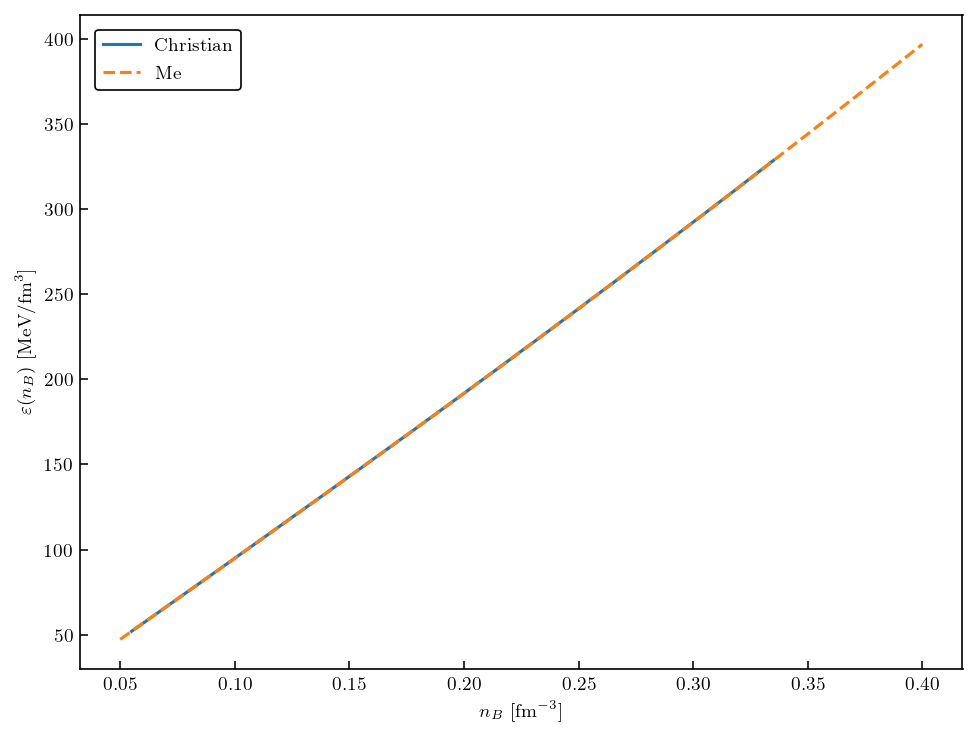

In [143]:
# comparison of energy densities with Christian's results
plt.plot(n3lo_nsm_mean[:,2], n3lo_nsm_mean[:,1], label=r'Christian')
plt.plot(density_all, eps_NSM, linestyle = 'dashed', label=r'Me')
plt.xlabel(r'$n_B$ [fm$^{-3}$]')
plt.ylabel(r'$\varepsilon(n_B)$ [MeV/fm$^3$]')
plt.legend()
plt.show()

# compare with actual values (means interpolation)
from scipy.interpolate import interp1d
interp_eps = interp1d(n3lo_nsm_mean[:,2], n3lo_nsm_mean[:,1], kind='cubic', fill_value='extrapolate')
eps_christian = interp_eps(density_all)

# print differences
#print((eps_christian - eps_NSM)/eps_NSM)

## Calculation of truncation error

Now we want to calculate the propagated error for $E_{NSM}$. This reads as

$$
\sigma_{E_{NSM}}^{2} = \left( \frac{\partial E_{NSM}}{\partial E_{PNM}} \right)^{2} \sigma_{E_{PNM}}^{2} + \left( \frac{\partial E_{NSM}}{\partial E_{SNM}} \right)^{2} \sigma_{E_{SNM}}^{2} + 2\rho \left( \frac{\partial E_{NSM}}{\partial E_{PNM}} \right) \left( \frac{\partial E_{NSM}}{\partial E_{SNM}} \right) \sigma_{E_{PNM}}\sigma_{E_{SNM}}.
$$

From the paper, we know that $\rho = 0.934$, so we will use this value and the standard deviations extracted from the chiral EFT code above to calculate the truncation error bands of the energy, and then propagate them to the pressure.

In [178]:
# calculation of the truncation error
rho = 0.934#, but 0.945 used in the BUQEYE notebooks

# separate out the std_devs for SNM, PNM (do order-by-order later)
std_s = energy_s_stds[:,3]
std_n = energy_n_stds[:,3]

# define the derivatives above
deriv_pnm = (1.0 - 2.0 * x)**2.0
deriv_snm = 4.0 * x * (1.0 - x) 

# calculate the final results (make a diagonal matrix to put in for the diagonal of the cov matrix)
sigma2_nsm = (deriv_pnm**2.0 * std_n**2.0 + deriv_snm**2.0 * std_s**2.0 + \
              2.0 * rho * deriv_pnm * deriv_snm * std_n * std_s)

# obtain sigma band
sigma_nsm = np.sqrt(sigma2_nsm)

# obtain upper and lower bands (envelopes, to be numerically differentiated)
e_NSM_lower = e_NSM - sigma_nsm
e_NSM_upper = e_NSM + sigma_nsm

---

### Full covariance matrix for $E_{NSM}(n_B)$

Instead of the above shortening, we will work with the full covariance matrices. We have obtained the full covariance matrix without even realising it when we worked with the symmetry energy above, so let's de-construct that and see what we can get.

0.9489034438537537


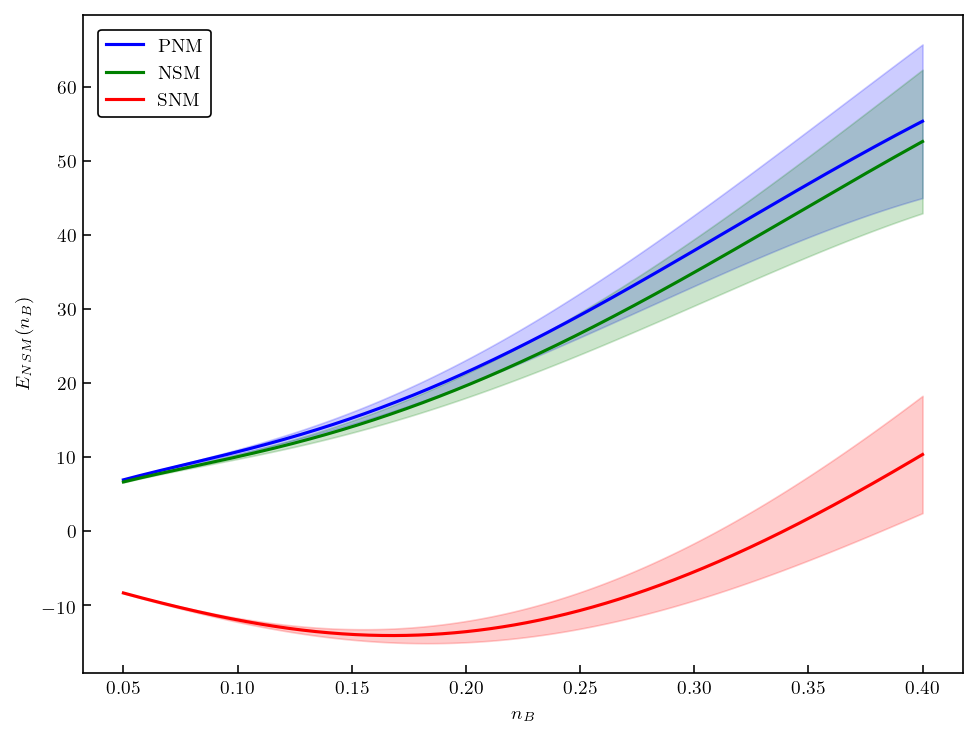

In [179]:
# same equation, different mistakes...?
print(rho_corr)  # use this, why not

# Kf_n = fermi_momentum(density_all, 2)[:, None]
# Kf_s = fermi_momentum(density_all, 4)[:, None]
# factor = 2. ** (1/3.)
# Kf_s = Kf_s * factor
# # ls_s = ls_s * factor

# # run the covariance matrix function for the full thing (for N3LO only -> kmin = 4)
# cov_corr_nsm = create_truncation_multi_covariance(Kf_n, Kf_s, cbar_n, cbar_s, ls1, ls2,
#         ref_2bf_func_n(Kf_n), ref_2bf_func_s(Kf_s),
#         ratio_kf(Kf_n, breakdown=chiral.breakdown), ratio_kf(Kf_s, breakdown=chiral.breakdown),
#         kmin=4, nugget=1e-10, rho=rho_sym_energy)

# print(cov_corr_nsm.shape)

# use the covariance matrix from symmetry energy calculation (modified)
cov_corr_nsm = cov_truncs[4]

# separate it out into pieces we'll need
N = len(density_all)

cov_pnm = cov_corr_nsm[:N,:N]
std_pnm = np.sqrt(np.diag(cov_pnm))
cov_snm = cov_corr_nsm[N:,N:]
std_snm = np.sqrt(np.diag(cov_snm))
cov_corr_ns = cov_corr_nsm[:N,N:]
cov_corr_sn = cov_corr_nsm[N:,:N]

# construct the overall covariance matrix
cov_corr = (deriv_pnm**2.0 * cov_pnm + deriv_snm**2.0 * cov_snm + \
              2.0 * rho * deriv_pnm * deriv_snm * cov_corr_ns)

# extract sigma
std_corr = np.sqrt(np.diag(cov_corr))

# plot the result
plt.plot(density_all, energy_n, label='PNM', color='blue')
plt.fill_between(density_all, energy_n-std_pnm, energy_n+std_pnm, color='blue', alpha=0.2)
plt.plot(density_all, e_NSM, label='NSM', color='green')
plt.fill_between(density_all, e_NSM-std_corr, e_NSM+std_corr, alpha=0.2, color='green')
plt.plot(density_all, energy_s, label='SNM', color='red')
plt.fill_between(density_all, energy_s-std_snm, energy_s+std_snm, color='red', alpha=0.2)
plt.xlabel(r'$n_{B}$')
plt.ylabel(r'$E_{NSM}(n_{B})$')
plt.legend(loc='upper left')
plt.show()

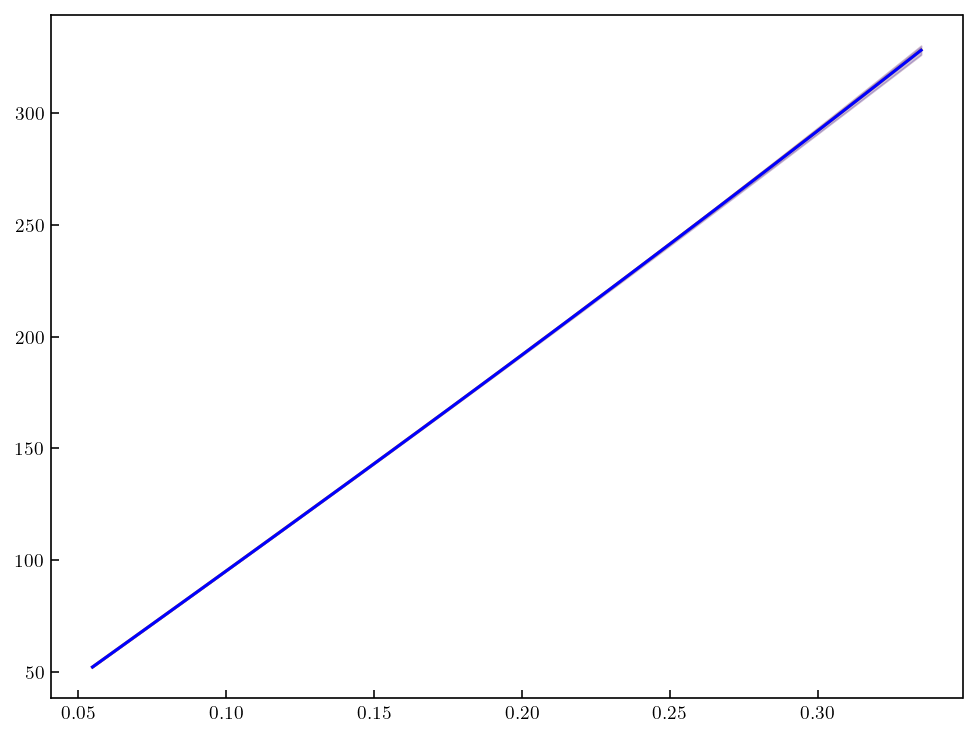

In [180]:
# comparison to Christian's results, and BUQEYE results in PNM, SNM
#print((std_pnm - energy_n_stds[:,3]))  # PNM confirmed
#print((std_snm - energy_s_stds[:,3]))   # SNM confirmed

# compare with actual values
from scipy.interpolate import interp1d
# interp_eps_mean = interp1d(n3lo_nsm_mean[:,2], n3lo_nsm_mean[:,1], kind='linear', fill_value='extrapolate')
# interp_eps_lower = interp1d(n3lo_nsm_lower[:,2], n3lo_nsm_lower[:,1], kind='linear', fill_value='extrapolate')
# interp_eps_upper = interp1d(n3lo_nsm_upper[:,2], n3lo_nsm_upper[:,1], kind='linear', fill_value='extrapolate')

# eps_christian_mean = interp_eps_mean(density_all)/density_all - hbarc*((mass_n + mass_p)/2.0)
# eps_christian_lower = interp_eps_lower(density_all)/density_all - hbarc*((mass_n + mass_p)/2.0)
# eps_christian_upper = interp_eps_upper(density_all)/density_all - hbarc*((mass_n + mass_p)/2.0)

# convert E/B to eps 
eps_NSM = (e_NSM + (hbarc*((mass_n + mass_p)/2.0)))*density_all
eps_NSM_lower = ((e_NSM-std_corr) + (hbarc * ((mass_n + mass_p)/2.0)))*density_all
eps_NSM_upper = ((e_NSM+std_corr) + (hbarc * ((mass_n + mass_p)/2.0)))*density_all

# solving my values at Christian's density grid
interp_eps_mean = interp1d(density_all, eps_NSM, kind='linear', fill_value='extrapolate')
interp_eps_lower = interp1d(density_all, eps_NSM_lower, kind='linear', fill_value='extrapolate')
interp_eps_upper = interp1d(density_all, eps_NSM_upper, kind='linear', fill_value='extrapolate')

eps_me_mean = interp_eps_mean(n3lo_nsm_mean[:,2])
eps_me_lower = interp_eps_lower(n3lo_nsm_mean[:,2])
eps_me_upper = interp_eps_upper(n3lo_nsm_mean[:,2])

# plot the results in E/B
plt.plot(n3lo_nsm_mean[:,2], n3lo_nsm_mean[:,1], color='orange', label=r'Christian E/B')
plt.fill_between(n3lo_nsm_mean[:,2], n3lo_nsm_lower[:,1], n3lo_nsm_upper[:,1], color='orange', alpha=0.2)
plt.plot(n3lo_nsm_mean[:,2], eps_me_mean, color='blue', label=r'My E/B')
plt.fill_between(n3lo_nsm_mean[:,2], eps_me_lower, eps_me_upper, alpha=0.2, color='blue')

In [181]:
print(((eps_me_upper-eps_me_mean) - (n3lo_nsm_upper[:,1]-n3lo_nsm_mean[:,1])))

[ 3.95078407e-03 -4.69641935e-03  6.95621667e-03 -1.05613314e-03
 -8.69563758e-03  4.07654649e-03 -2.70038441e-03 -8.98352359e-03
  5.26722934e-03  9.89785193e-05  5.55342253e-03  4.16794432e-02
  4.85228684e-02  5.61331195e-02  6.45607311e-02  7.38550738e-02
 -1.59279675e-02 -4.73928706e-03  7.47970981e-03  2.07605705e-02
  3.51689218e-02  5.07621833e-02 -3.23994411e-02 -1.42541394e-02
 -9.47437168e-02 -7.37993882e-02 -5.13642442e-02 -2.73641255e-02
 -1.73942985e-03 -7.44158846e-02  5.46740231e-02 -1.43973246e-02
 -8.15534064e-02  5.32756198e-02  9.01764671e-02 -7.07825152e-02
 -2.95083541e-02  1.40724180e-02 -3.99477080e-02 -9.14839729e-02
  5.95533317e-02  1.32617088e-02 -3.02726479e-02 -7.09379095e-02
 -8.64919049e-03  5.67124236e-02 -7.47590233e-02 -2.94564791e-03
 -2.77374117e-02 -4.90199063e-02 -6.66651122e-02  1.94370714e-02
 -9.05651746e-02  3.43789412e-03  1.60243918e-03  4.05382539e-03
  1.09467804e-02]


---

## Calculation of $P(n)$ <a id="calc_p"></a>

The pressure for neutron star matter is given by
$$ 
P(n_B) = n_B^2 \frac{dE_{NSM}}{dn_B}.
$$

We will attempt this by simple numerical differentiation of the mean curve from the above calculation, and the envelopes of the truncation error.

In [28]:
## process: 

# 1) Calculate the pressure using numerical differentiation
# 2) Use the mean to get the mean curves for N2LO, N3LO
# 3) Employ the numerical differentiation to get envelopes from E_NSM
# 4) Plot the envelopes
# 5) Compare to Christian's results below

# calculate the pressure using numerical differentiation
#! pip install fderiv
from fderiv import fderiv
de_nsm, tol = fderiv(density_all, e_NSM)
de_nsm_lower, tol = fderiv(density_all, e_NSM_lower)
de_nsm_upper, tol = fderiv(density_all, e_NSM_upper)

# pressure calculation
p_NSM = density_all**2.0 * de_nsm
p_NSM_lower = density_all**2.0 * de_nsm_lower
p_NSM_upper = density_all**2.0 * de_nsm_upper

p_NSM_N3LO = p_NSM

# envelope calculaton
p_NSM_N3LO_lower = p_NSM_lower
p_NSM_N3LO_upper = p_NSM_upper

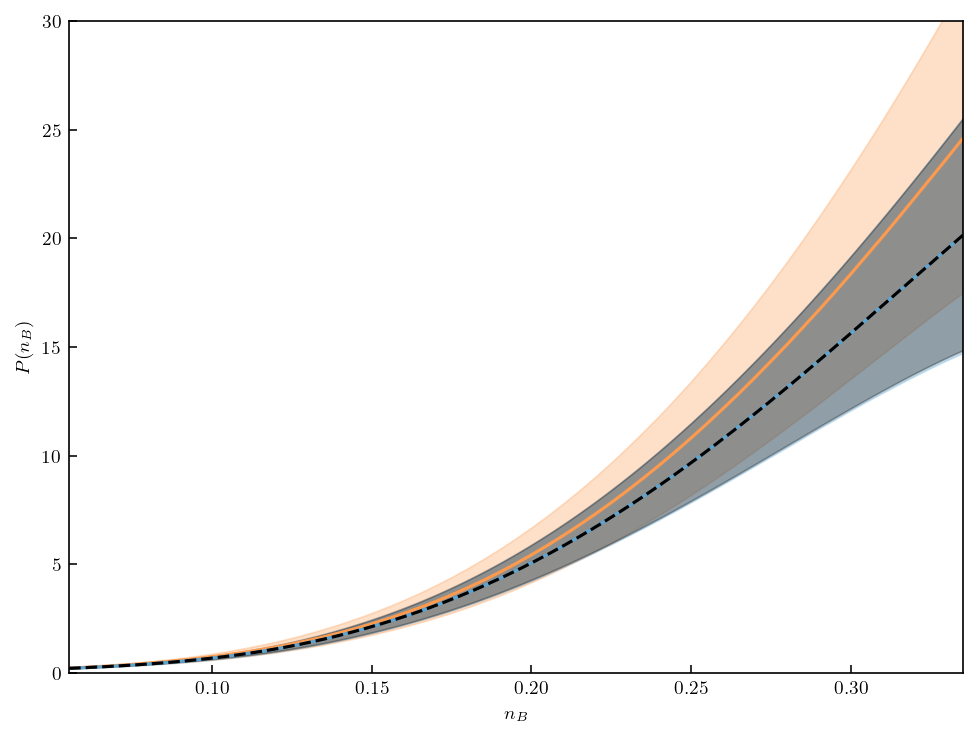

In [29]:
# to compare, plot results from Christian (N2LO & N3LO only)

# plot the results
plt.plot(n2lo_nsm_mean[:,2], n2lo_nsm_mean[:,0], color=colors[0])
plt.fill_between(n2lo_nsm_mean[:,2], n2lo_nsm_lower[:,0], n2lo_nsm_upper[:,0], alpha=0.3, color=colors[0])
plt.plot(n3lo_nsm_mean[:,2], n3lo_nsm_mean[:,0], color=colors[2])
plt.fill_between(n3lo_nsm_mean[:,2], n3lo_nsm_lower[:,0], n3lo_nsm_upper[:,0], alpha=0.3, color=colors[2])
#plt.plot(density_all, p_NSM_N2LO, 'k', linestyle='dashed')
plt.plot(density_all, p_NSM_N3LO, 'k', linestyle='dashed')
#plt.fill_between(density_all, p_NSM_N2LO_lower, p_NSM_N2LO_upper, alpha=0.3, color='k')
plt.fill_between(density_all, p_NSM_N3LO_lower, p_NSM_N3LO_upper, alpha=0.3, color='k')
plt.xlabel(r'$n_{B}$')
plt.ylabel(r'$P(n_{B})$')
plt.ylim(0.0, 30.0)
# plt.ylim(0.0, 1.0)
# plt.xlim(0.05, 0.1)
plt.xlim(min(n3lo_nsm_mean[:,2]), max(n3lo_nsm_mean[:,2]))
plt.show()

In [30]:
# checking result explicitly using interpolation and subtraction for means first
from scipy.interpolate import interp1d
interp_p = interp1d(density_all, p_NSM_N3LO, kind='linear', fill_value='extrapolate')
p_result = interp_p(n3lo_nsm_mean[:,2])

print((p_result - n3lo_nsm_mean[:,0])/p_result)

[-9.72430697e-04 -1.12712376e-03 -1.25324469e-03 -1.44940434e-03
 -1.30107330e-03 -1.19714314e-03 -1.12500773e-03 -1.16217317e-03
 -9.43842577e-04 -8.67224566e-04 -7.97962418e-04 -6.84386659e-04
 -4.89117458e-04 -9.76590357e-06 -4.47994279e-05 -5.53136356e-04
 -3.10250536e-04 -3.84064584e-04 -4.70671237e-06  1.97386233e-04
  9.09257243e-05  8.08066640e-05 -1.02185745e-05 -1.95725388e-05
  1.20889079e-04  1.95478968e-04 -1.11011382e-06  1.07964690e-04
  3.23961242e-05  2.69684489e-05  6.84981699e-05  1.35405766e-04
  4.63233406e-05  9.43102910e-05  9.16393179e-05 -2.64836702e-06
  4.10702132e-05  2.75305694e-05  2.92114732e-05  9.01535989e-05
  4.36407258e-04  3.15989412e-04  4.36217130e-04 -1.35576187e-04
  2.22543120e-04 -2.03606609e-04  7.12147217e-05  1.90606504e-04
  9.97450727e-05  3.88897488e-04  3.23803993e-04  4.58241433e-04
  1.23897761e-04  3.90129433e-04  5.51221797e-05  1.24626632e-04
  4.79178666e-04]


In [31]:
# checking result explicitly using interpolation and subtraction for means first
from scipy.interpolate import interp1d
interp_p = interp1d(density_all, p_NSM_N3LO, kind='cubic', fill_value='extrapolate')
p_result = interp_p(n3lo_nsm_mean[:,2])

print((p_result - n3lo_nsm_mean[:,0])/p_result)

[-9.92963603e-04 -1.13618467e-03 -1.27395458e-03 -1.46676787e-03
 -1.31798891e-03 -1.22017054e-03 -1.13414747e-03 -1.18714474e-03
 -9.45230184e-04 -8.90470137e-04 -8.08192860e-04 -7.03076202e-04
 -5.04255181e-04 -2.21472091e-05 -6.15134025e-05 -5.58467725e-04
 -3.26092150e-04 -3.85709847e-04 -1.47632660e-05  1.91741361e-04
  8.16811666e-05  7.28753822e-05 -1.60912466e-05 -2.80408862e-05
  1.18650114e-04  1.87633526e-04 -2.30745082e-06  1.01466388e-04
  2.90708184e-05  2.22227545e-05  6.42440021e-05  1.32580899e-04
  4.19749993e-05  9.33984206e-05  8.77484063e-05 -3.41774055e-06
  3.79676868e-05  2.58333142e-05  2.70567616e-05  8.81402044e-05
  4.35225770e-04  3.14071141e-04  4.35924106e-04 -1.37150420e-04
  2.22179036e-04 -2.04717142e-04  7.06080795e-05  1.89969132e-04
  9.91890351e-05  3.88649500e-04  3.23468426e-04  4.58219104e-04
  1.23847819e-04  3.90159805e-04  5.53323788e-05  1.24862456e-04
  4.79541401e-04]


### Getting a covariance matrix, idea 1: quick and dirty GP estimate

In [27]:
# fitting a GP to this data (let's see how the error bands look!)
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern

# fit to some sparse spacing of points and predict to all later on (using MY results)
data = p_NSM_N3LO
sigma = p_NSM_N3LO_upper - p_NSM_N3LO
tr_dens = density_all[1::5]
pre_dens = density_all
tr_data = data[1::5]
tr_sigma = sigma[1::5]
pre_data = data
pre_sigma = sigma

# set up a kernel that exactly mimics the envelope
kernel = RBF(length_scale=0.007, length_scale_bounds='fixed') * ConstantKernel(1e10, constant_value_bounds='fixed')
gp_nsm = GPR(kernel=kernel, n_restarts_optimizer=10, alpha=1.17*np.square(tr_sigma))
gp_nsm.fit(tr_dens.reshape(-1,1), tr_data.reshape(-1,1))

# print the kernel parameters to check constraints
print(gp_nsm.kernel_)

# predict for cov matrix and extract std_dev values from diagonal
pre_data, cov_pre_data = gp_nsm.predict(pre_dens.reshape(-1,1), return_cov=True)
std_nsm = np.sqrt(np.diag(cov_pre_data))  # NSM std_dev; keep for the diagonal of PNM matrix!

RBF(length_scale=0.007) * 1e+05**2


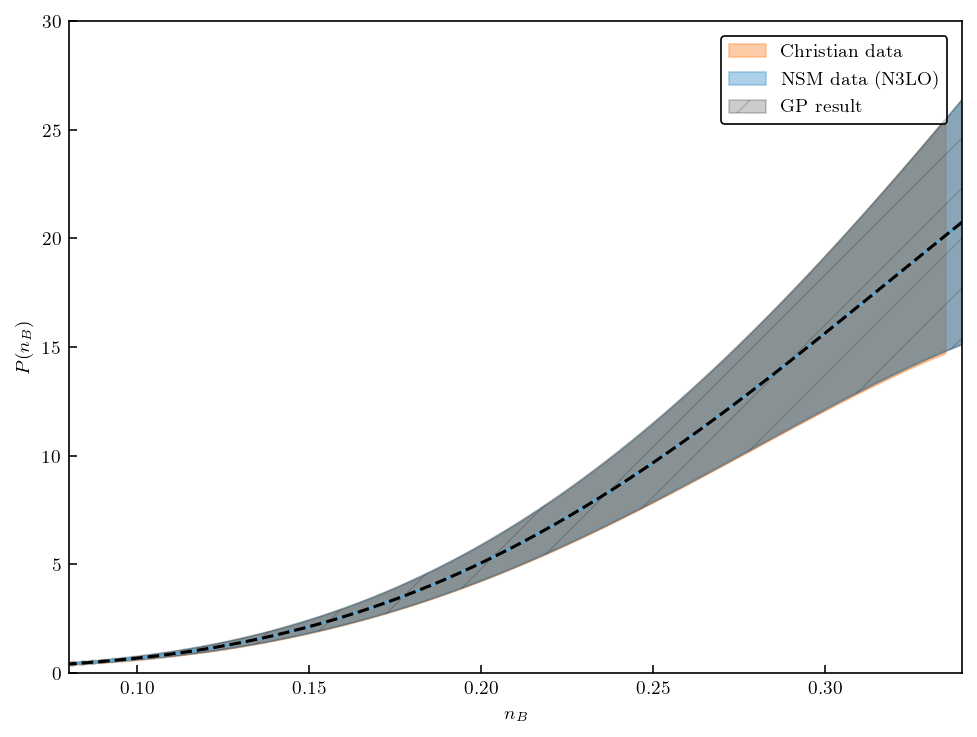

In [29]:
# plot the result, see how bad it is
plt.plot(n3lo_nsm_mean[:,2], n3lo_nsm_mean[:,0], color=colors[0])
plt.fill_between(n3lo_nsm_mean[:,2], n3lo_nsm_lower[:,0], n3lo_nsm_upper[:,0], alpha=0.5, color=colors[0], \
                 label='Christian data')
plt.plot(density_all, p_NSM_N3LO, color=colors[2])
plt.fill_between(density_all, p_NSM_N3LO_lower, p_NSM_N3LO_upper, alpha=0.5, color=colors[2], \
                 label=r'NSM data (N3LO)')
plt.plot(pre_dens, pre_data, 'k', linestyle='dashed')
plt.fill_between(pre_dens, pre_data-std_nsm, pre_data+std_nsm, alpha=0.2, color='k', \
                 hatch='/', label=r'GP result')
plt.xlabel(r'$n_{B}$')
plt.ylabel(r'$P(n_{B})$')
plt.ylim(0.0, 30.0)
plt.xlim(0.08, 0.34)
plt.legend()
plt.show()

In [30]:
# try comparing the two
print((std_nsm[52:497] - pre_sigma[52:497])) # not exact, but we didn't expect this did we

[0.03932005 0.07232461 0.06953983 0.03483665 0.00305459 0.02961342
 0.05691905 0.05530846 0.02754715 0.00350976 0.02308016 0.04576868
 0.0449918  0.02252672 0.00390344 0.01857417 0.0375975  0.037487
 0.01921182 0.00435882 0.01549145 0.03150352 0.0319173  0.01686041
 0.00483077 0.01344471 0.02703984 0.02776463 0.01542299 0.00541932
 0.01209404 0.02366997 0.02471328 0.0144126  0.00601174 0.0111748
 0.02122444 0.02240537 0.01385332 0.00652746 0.01069926 0.01938607
 0.02077103 0.01351131 0.00713649 0.01045327 0.01803146 0.01960144
 0.01343679 0.00783504 0.01041431 0.01700687 0.01867891 0.01355323
 0.00851865 0.01054347 0.01640862 0.01812807 0.01374672 0.00925765
 0.01082111 0.01599463 0.01776586 0.01405401 0.01000007 0.0111993
 0.01579607 0.01757939 0.01445769 0.01082664 0.0116872  0.01576687
 0.01755084 0.0149327  0.01166485 0.01224372 0.01586409 0.01763677
 0.01548112 0.01251661 0.0128959  0.01607848 0.0178471  0.01608195
 0.01339185 0.01360568 0.01642792 0.01812872 0.01671671 0.01433682

In [46]:
# save the data to a file once scaled and try it on the BMM side
# scaling process
n0 = 0.164

# also calculate the Fermi gas pressure now (let's get pQCD FG pressure first)
#pressure_free = ((3.0/(4.0*np.square(np.pi)))*(chiral.kf_s_all**4.0))*(hbarc)
p_fg = np.load('../data/eos_data/pqcd_fg_data_NSM.npz')

# interpolate and assign the correct points
from scipy.interpolate import interp1d
p_interp_fg = interp1d(p_fg['density'], p_fg['mean'], kind='cubic', fill_value='extrapolate')
pressure_free = p_interp_fg(density_all)

# scaling here
pre_data_scaled = np.zeros([len(density_all)])
std_nsm_scaled = np.zeros([len(density_all)])
cov_pre_data_scaled = np.zeros([len(density_all), len(density_all)])
 
# scale mean, std_dev (from DATA)
pre_data_scaled = pre_data/pressure_free
std_nsm_scaled = std_nsm/pressure_free
    
# scale covariance matrix (combined one from above)
for j in range(len(density_all)):
    for k in range(len(density_all)):
        cov_pre_data_scaled[j,k] = cov_pre_data[j,k]/(pressure_free[j]*pressure_free[k])

# saving
np.savez('chiral_idea_1.npz', density=density_all[52:497], mean=pre_data_scaled[52:497], \
         std_dev=std_nsm_scaled[52:497], cov=cov_pre_data_scaled[52:497, 52:497])

### Constructing a covariance matrix, idea 2: using the covariance matrix of PNM

In [47]:
# call the chiral pressure function for PNM
pressures_n, pressure_n_stds, pressure_n_cov = chiral.pressure(orders='all', matter='PNM')

# call the chiral pressure function for SNM
pressures_s, pressure_s_stds, pressure_s_cov = chiral.pressure(orders='all', matter='SNM')

# separate out only N3LO (easier testing purposes)
p_pnm = pressures_n[:,3]
p_std_pnm = pressure_n_stds[:,3]
p_cov_pnm = pressure_n_cov[:,:,3]
p_snm = pressures_s[:,3]
p_std_snm = pressure_s_stds[:,3]
p_cov_snm = pressure_s_cov[:,:,3]

# generate matrix from PNM
p_cov_NSM = p_cov_pnm.copy()

In [48]:
# form giant covariance matrix
# from scipy.linalg import block_diag

# giant_cov = block_diag(pressure_n_cov[:,:,3], pressure_s_cov[:,:,3])

# giant_cov[:600,600:] = rho * pressure_n_cov[:,:,3]
# giant_cov[600:,:600] = rho * pressure_n_cov[:,:,3]
        
# print(giant_cov)

# construct the covariance matrix we need for full NSM matrix (this time, just PNM covariance matrix)
cov_NSM = p_cov_NSM 

print(cov_NSM.shape)

(600, 600)


In [49]:
# scale the data to test it
n0 = 0.164

# also calculate the Fermi gas pressure now (let's get pQCD FG pressure first)
#pressure_free = ((3.0/(4.0*np.square(np.pi)))*(chiral.kf_s_all**4.0))*(hbarc)
p_fg = np.load('../data/eos_data/pqcd_fg_data_NSM.npz')

# interpolate and assign the correct points
from scipy.interpolate import interp1d
p_interp_fg = interp1d(p_fg['density'], p_fg['mean'], kind='cubic', fill_value='extrapolate')
pressure_free = p_interp_fg(density_all)

# scaling here
mean_chiral_pressure_scaled = np.zeros([len(density_all)])
std_dev_chiral_pressure_scaled = np.zeros([len(density_all)])
cov_NSM_scaled = np.zeros([len(density_all), len(density_all)])
 
# scale mean, std_dev (from DATA)
mean_chiral_pressure_scaled = pre_data/pressure_free
std_dev_chiral_pressure_scaled = pre_sigma/pressure_free
    
# scale covariance matrix (combined one from above)
for j in range(len(density_all)):
    for k in range(len(density_all)):
        cov_NSM_scaled[j,k] = cov_NSM[j,k]/(pressure_free[j]*pressure_free[k])

In [50]:
# save the data to a file for use in the GP BMM notebook after scaling
np.savez('quick_cheft_data.npz', density=density_all[52:497], \
         mean=mean_chiral_pressure_scaled[52:497], std_dev=std_dev_chiral_pressure_scaled[52:497], \
         cov=cov_NSM_scaled[52:497, 52:497])

From here, we move to the BMM GP notebook for NSM, so that we get to see how this covariance matrix affects our results when we go to use it in the BMM case. Another possible check: training a GP with the same covariance matrix over the data from here, NOT over the whole ChEFT-pQCD space. That might tell us the coverage of our matrix.

### Testing the covariance matrix from ideas 1 and 2: training a GP on the data

In [172]:
### code here ###

### algorithm ###
# 1) Feed 2d alpha GP the covariance matrix we just devised
# 2) Plot result of this training over the original P(nB) data curve
# 3) This way, we can check the coverage of the bands somewhat

In [173]:
# import packages
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from gp_utils import GaussianProcessRegressor2dNoise

#### Idea 1: quick and dirty GP fit

In [192]:
# fit on 10 points or less for the 2d alpha GP
training_data_1 = {
    'dens': density_all[52:497],
    'mean': pre_data[52:497],
    'std': std_pre_data[52:497],
    'cov': cov_pre_data[52:497,52:497]
}

# train the GP using the above data
kernel = C(constant_value=0.6) * Matern(length_scale=1.5, nu=1.5)

X_train = np.log(training_data_1['dens'][::60]).reshape(-1,1)  # training in the log scale
y_train = training_data_1['mean'][::60].reshape(-1,1)

# set up the class for the GP
gp_1 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_1['cov'][::60,::60]  # here is where we input the full covariance matrix from the data
)

gp_1.fit(X_train, y_train)  # fit to the data we selected from chiral EFT & pQCD

# print the kernel params
print(gp_1.kernel_)

# predict on new density array
density_test = np.linspace(min(density_all), max(density_all), 100)
X = np.log(density_test).reshape(-1,1)
y_pred, y_stdv = gp_1.predict(X, return_std=True)

13**2 * Matern(length_scale=2.24, nu=1.5)


#### Idea 2: Using PNM covariance matrix 

In [207]:
# fit on 10 points or less for the 2d alpha GP
training_data_2 = {
    'dens': density_all[::100],
    'mean': pre_data[::100],
    'std': pre_sigma[::100],
    'cov': cov_NSM[::100,::100]
}

# train the GP using the above data
kernel = C(constant_value=0.6) * RBF(length_scale=0.05)#Matern(length_scale=2.0, nu=1.5)

X_train = np.log(training_data_2['dens']).reshape(-1,1)  # training in the log scale
y_train = training_data_2['mean'].reshape(-1,1)

# set up the class for the GP
gp_2 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov']  # here is where we input the full covariance matrix from the data
)

gp_2.fit(X_train, y_train)  # fit to the data we selected from chiral EFT & pQCD

# print the kernel params
print(gp_2.kernel_)

# predict on new density array
density_test_2 = np.linspace(min(density_all[52:497]), max(density_all[52:497]), 100)
X_2 = np.log(density_test_2).reshape(-1,1)
y_pred_2, y_stdv_2 = gp_2.predict(X_2, return_std=True)

5.14**2 * RBF(length_scale=0.529)


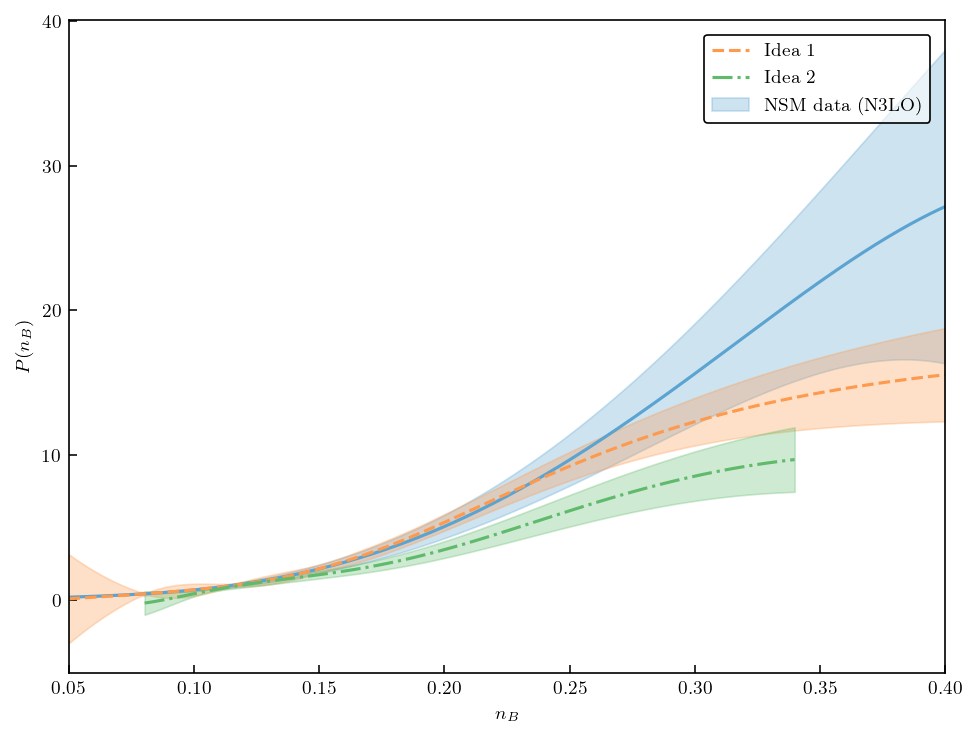

[ 2.27496399  1.89654778  1.54950325  1.23076567  0.93795061  0.66932634
  0.42382319  0.20134391  0.00731292  0.00431033  0.18295138  0.28661728
  0.32362952  0.3133727   0.2680917   0.19651573  0.10667434  0.0087091
 -0.07538214 -0.08938499 -0.0388061   0.01587467  0.05631989  0.0789748
  0.08440617  0.07522977  0.05583461  0.03260903  0.01390069  0.00797643
  0.01437963  0.02632968  0.03856705  0.04812643  0.05385266  0.05583118
  0.05496795  0.05268323  0.05065009  0.05042203  0.05201434  0.05456247
  0.05739274  0.06008431  0.06246089  0.06455658  0.06657158  0.06882503
  0.07170859  0.07559919  0.08049134  0.08621653  0.09266479  0.09978486
  0.10757748  0.1160861   0.12538666  0.13557749  0.14676983  0.15905955
  0.17240915  0.18673626  0.20197287  0.21806444  0.23496819  0.25265124
  0.27108866  0.29026162  0.31015571  0.3307493   0.35197042  0.37373619
  0.39597099  0.41860614  0.44157937  0.4648344   0.48832041  0.51199155
  0.53580655  0.55972269  0.58367887  0.60761373  0.6

In [210]:
# plot the result over top of the original to see the differences
plt.plot(density_all, p_NSM_N3LO, color=colors[2])
plt.fill_between(density_all, p_NSM_N3LO_lower, p_NSM_N3LO_upper, alpha=0.3, color=colors[2], \
                 label=r'NSM data (N3LO)')

plt.plot(density_test, y_pred, color=colors[0], linestyle='dashed', label=r'Idea 1')
plt.fill_between(density_test, y_pred-y_stdv, y_pred+y_stdv, alpha=0.3, color=colors[0])

plt.plot(density_test_2, y_pred_2, color=colors[1], linestyle='dashdot', label=r'Idea 2')
plt.fill_between(density_test_2, y_pred_2-y_stdv_2, y_pred_2+y_stdv_2, alpha=0.3, color=colors[1])

plt.xlabel(r'$n_{B}$')
plt.ylabel(r'$P(n_{B})$')
plt.xlim(min(density_all), max(density_all))
plt.legend()
plt.show()

print(y_stdv - y_stdv_2) # overall, the quick and dirty one is bigger when trained here...

## SNM pressure 

In [156]:
# # set the value of saturation density
# n0 = 0.164

# # set the value of hbarc
# hbarc = 197.327 # MeV fm

# # also calculate the Fermi gas pressure now for scaling later
# pressure_free = np.zeros([len(density_all), 4])
# for i in range(4):
#     pressure_free[:,i] = ((1.0/(2.0*np.square(np.pi)))*(chiral.kf_s_all**4.0))*(hbarc)

In [62]:
# calculate the values of Q at each point in density space
def q_calc(density):
    # momentum first from density_all
    hbarc = 197.327 # MeV fm 
    kf = ((3.0*np.pi**2.0)*density/2.0)**(1.0/3.0)  # fm^-1
    lamb = 600./hbarc   # MeV/MeV fm = fm^-1
    Q_vals = kf/lamb
    
    return Q_vals

# calculate the value of Q at 0.239 fm^-3
q_calc(0.65)

# calculate it only between the current 
# limits of density on the plot
# current_lims = [0.05/n0, 2.0/n0]
# q_vals = q_calc(density_all)

0.699525230490762

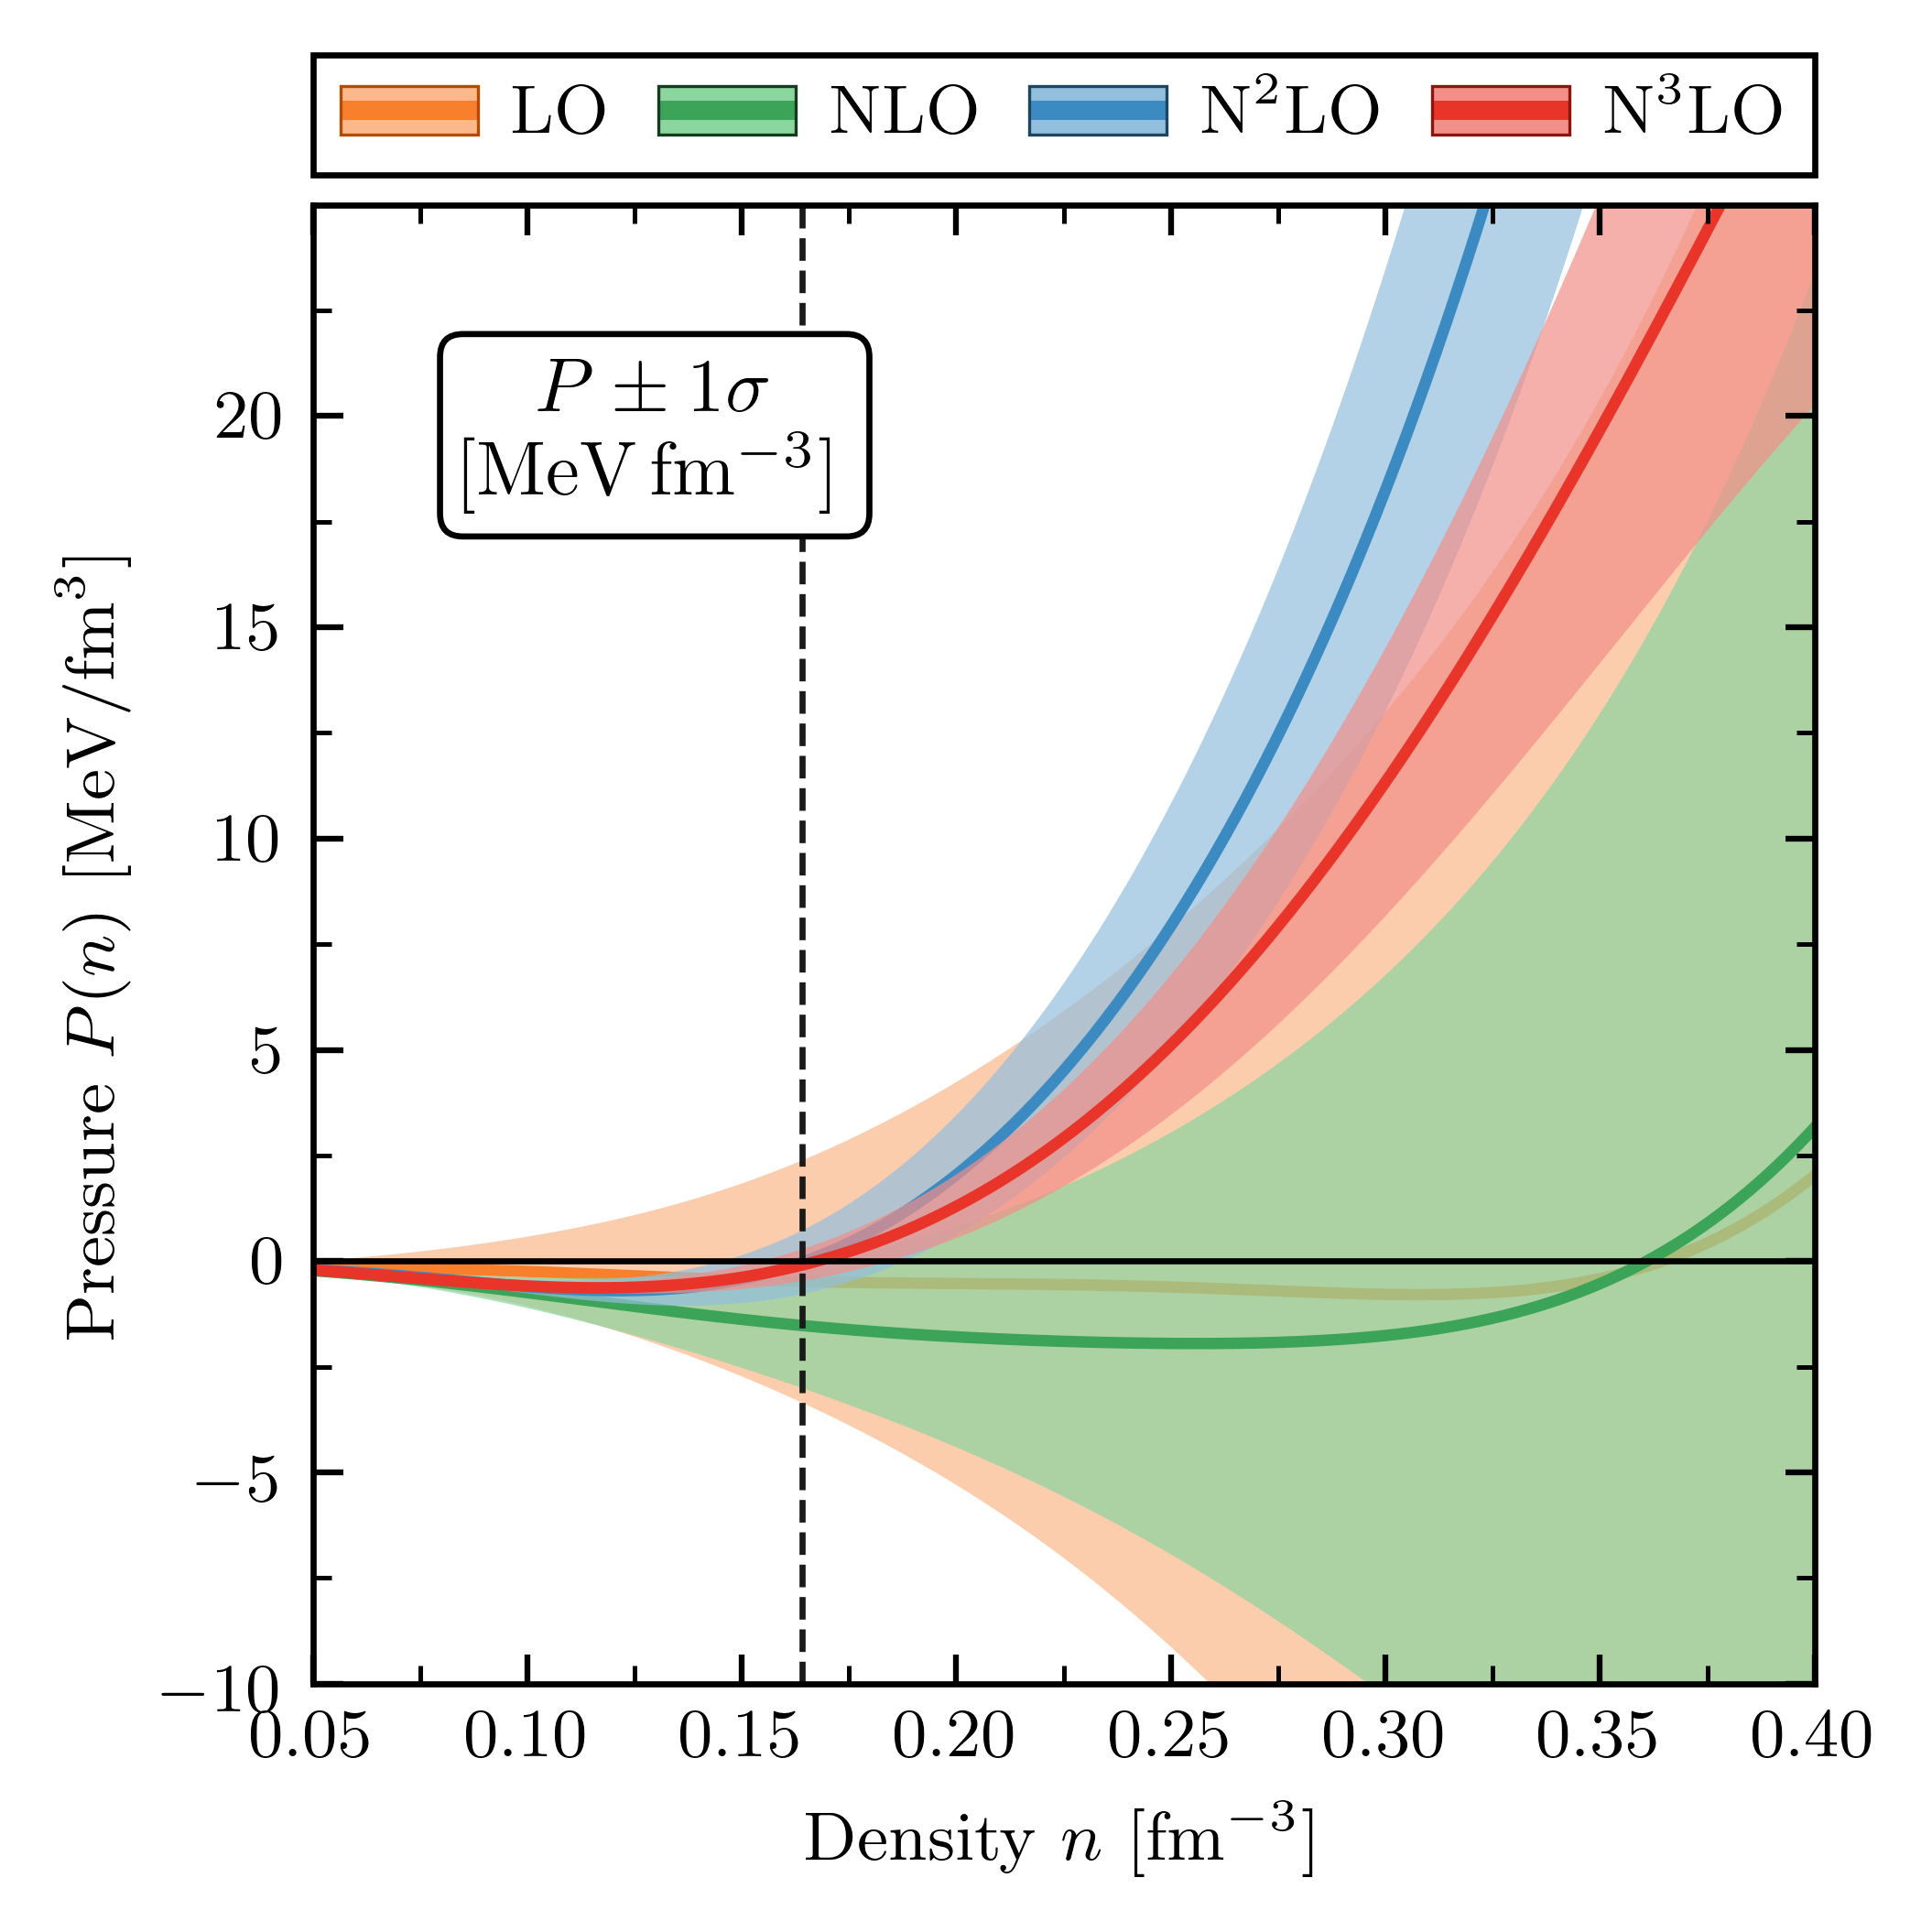

In [63]:
# Fig. 1 of the paper
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
from nuclear_matter import lighten_color
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        pressures_s[:,i],
        pressure_s_stds[:,i],
        ax=ax,
        color_68=light_colors[i],
   #     color_95=light_colors[i],
        c=colors[i],
        add_nsat=i==len(chiral.orders)-1,
        zorder=i/10,
    )
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both') # stop for loop after line
ax.axhline(0, 0, 1, c='k', lw=0.8);
ax.set_ylabel(r'$\textrm{Pressure}~P(n)$ [MeV/fm$^{3}$]');
ax.set_ylim(-10, 25-1e-5);
label = r"""$P \pm 1\sigma$
[MeV\,fm$^{-3}$]"""
ax.text(
    0.1, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
#fig.savefig('pressure_n_2n0.PNG')
plt.show()

In [ ]:
# Fig. 6 of this paper, with extended results (uncomment all below to generate)
# fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
# from nuclear_matter import lighten_color
# color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
# cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
# colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
# light_colors = [lighten_color(color, 0.55) for color in colors]
# dark_colors = [lighten_color(color, 1.5) for color in colors]
# for i, n in enumerate(chiral.orders):
#     plot_obs_vs_density(
#         density_all/n0,
#         pressures_s[:,i]/pressure_free[:,i],
#         pressure_s_stds[:,i]/pressure_free[:,i],
#         ax=ax,
#         color_68=light_colors[i],
#    #     color_95=light_colors[i],
#         c=colors[i],
#         add_nsat=i==len(chiral.orders)-1,
#         nsat_n0 = False,
#         zorder=i/10,
#     )
# ax.xaxis.set_major_locator(MultipleLocator(0.05))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax.tick_params(right=True, top=True, which='both') # stop for loop after line
# ax.axhline(0, 0, 1, c='k', lw=0.8);
# #ax.axvline(0.34/n0, c='grey', lw=0.8, linestyle='dashdot');
# ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]);
# ax.set_xlim(0.05/n0, 2.0/n0)
# #ax.set_xlim(0.05, 16.4)
# #ax.set_xlim(min(density_all), max(density_all))

# # # add Q value lines
# ax.axvline(x=0.239/0.164, linestyle='dotted', alpha=1., color='grey', zorder=10)
# ax.axvline(x=0.65/0.164, linestyle='dotted', alpha=1., color='grey', zorder=10)
# ax.axvline(x=1.90/0.164, linestyle='dotted', alpha=1., color='grey', zorder=10)

# #add a secondary x axis with Q on it
# # ax2 = ax.twiny()
# # ax2.set_xlabel('Q')
# # ax2.xaxis.set_major_formatter(plt.FuncFormatter(q_calc))

# #ax.set_xscale('log')
# ax.set_ylabel(r'Scaled pressure $P(n)/P_{FG}(n)$');
# ax.set_xlabel(r'$n/n_{0}$')
# #ax.set_ylim(-10, 25-1e-5);  # old one
# ax.set_ylim(0.0, 50.0)
# label = r"""$P(n)/P_{FG}(n) \pm 1\sigma$"""
# ax.text(
#     0.2, 0.85, label, transform=ax.transAxes, ha='left', va='top',
#     multialignment='center', zorder=10, fontsize=10,
#     bbox=dict(facecolor='w', boxstyle='round')
# )
# add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
## fig.savefig('pressure_scaled_trunc.PNG')
# plt.show()

In [ ]:
# call pressure from chiral.py to save to a file for later use
pressure_s, pressure_s_stds, pressure_s_cov = chiral.pressure(orders='all')
mean_chiral_pressure = pressure_s
std_dev_chiral_pressure = pressure_s_stds
cov_matrix_chiral_pressure = pressure_s_cov

# write this to a file (uncomment to save if desired)
# if density_all.size >= 600:
#     np.savez('pressure_chiral_data', density=density_all, dens_scaled=density_all/n0, mean=mean_chiral_pressure, std_dev=std_dev_chiral_pressure, \
#              cov=cov_matrix_chiral_pressure)

#     # open the file here and check it
#     npzfile = np.load('pressure_chiral_data.npz')
#     npzfile.files

#     print(npzfile['mean'].shape, npzfile['std_dev'].shape, npzfile['cov'].shape)

#     std_from_cov = np.sqrt(np.diag(npzfile['cov'][:,:,3]))
#     print(std_from_cov - npzfile['std_dev'][:,3])
# else:
#     print('Not saved.')

In [ ]:
# divide out by the free quark pressure (checking against the plot in chiral EFT in the SNM paper)
dens_scale = density_all/n0
min_dens = np.where(dens_scale>=1.)[0][0]
max_dens = np.where(dens_scale>=2.)[0][0]
dens_scale = dens_scale[min_dens-1:max_dens]

fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.axes()
ax.plot(dens_scale, pressures_s[min_dens-1:max_dens,3]/pressure_free[min_dens-1:max_dens,3], color='red')
ax.fill_between(dens_scale, \
                (pressures_s[min_dens-1:max_dens,3]-pressure_s_stds[min_dens-1:max_dens,3])/pressure_free[min_dens-1:max_dens,3], \
                (pressures_s[min_dens-1:max_dens,3]+pressure_s_stds[min_dens-1:max_dens,3])/pressure_free[min_dens-1:max_dens,3], \
                color='red', alpha=0.2)
ax.set_xscale('log')
axes[0, 0].set_ylim(-20, 25)
axes[1, 0].set_ylim(-20, 25)
label = r"""$P \pm 1\sigma$
[MeV\,fm$^{-3}$]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

In [ ]:
# # saving the scaled results also to an npz file
mean_chiral_pressure_scaled = np.zeros([len(density_all,), 4])
std_dev_chiral_pressure_scaled = np.zeros([len(density_all), 4])
cov_matrix_chiral_pressure_scaled = np.zeros([len(density_all), len(density_all), 4])

for i in range(len(chiral.orders)):
    mean_chiral_pressure_scaled[:,i] = pressure_s[:,i]/pressure_free[:,i]
    std_dev_chiral_pressure_scaled[:,i] = pressure_s_stds[:,i]/pressure_free[:,i]
                            
for i in range(len(chiral.orders)):
    for j in range(len(density_all)):
        for k in range(len(density_all)):
            cov_matrix_chiral_pressure_scaled[j,k,i] = pressure_s_cov[j,k,i]/(pressure_free[j,i]*pressure_free[k,i])
    
#write this to a file (uncomment to do this)
# if density_all.size >= 600:
#     np.savez('../data/eos_data/pressure_chiral_data_scaled_PAL', density=density_all, dens_scaled=density_all/n0, mean=mean_chiral_pressure_scaled, std_dev=std_dev_chiral_pressure_scaled, \
#              cov=cov_matrix_chiral_pressure_scaled)

#     # open the file here and check it
#     npzfile_scaled = np.load('../data/eos_data/pressure_chiral_data_scaled_PAL.npz')
#     npzfile_scaled.files

#     print(npzfile_scaled['mean'].shape, npzfile_scaled['std_dev'].shape, npzfile_scaled['cov'].shape)

#     # checking the correctness
#     print(np.sqrt(np.diag(npzfile_scaled['cov'][:,:,3])) - npzfile_scaled['std_dev'][:,3])
    
# elif density_all.size <= 300:
#     np.savez('../data/eos_data/pressure_chiral_data_scaled_2n0', density=density_all, dens_scaled=density_all/n0, mean=mean_chiral_pressure_scaled, std_dev=std_dev_chiral_pressure_scaled, \
#              cov=cov_matrix_chiral_pressure_scaled)
# else:
#     print('Not saved.')

---
## Obtaining $\varepsilon(n)$ <a id="calc_eps"></a>

We also want to determine $\varepsilon(n)$, as we will need values of this quantity for calculating the speed of sound in the mixed model of Sec. III in our paper. This is done by calculating

$$
\varepsilon(n) = \frac{1}{n}\left[\frac{E(n)}{A} + M\right] 
$$

In [ ]:
# call the chiral function
energy_density_s, energy_density_s_stds = chiral.energy_dens(add_rest_mass=True)
    
# plot the energy density now wrt n 
fig, axes = plot_obs_panels(
    density_all, y=energy_density_s, dy=energy_density_s_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

label = r"""$\varepsilon \pm 1\sigma$
[MeV/fm$^3$]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

# save the energy density array to a file (uncomment to save)
#np.savez('../data/eos_data/edens_data_chiral.npz', density=density_all, mean=energy_density_s[:,3], std=energy_density_s_stds[:,3])

---

## Calculation of the speed of sound squared, $c_{s}^{2}$ <a id="cs2"></a>

Now we want to calculate the speed of sound. This can be done via the simple relation

$$
c_{s}^{2} = \frac{\partial P(n)}{\partial \varepsilon(n)},
$$

which is what the source code calculates when we look at sampling the speed of sound below. 

To make sure that our speed of sound truncation error is not overestimated, we need to preserve the correlations between the quantities involved and their derivatives. Hence, we use the GP and its derivatives to do this, and sample from the GP so that correlations are preserved. 

__NOTE__: The speed of sound __cannot__ be calculated for densities outside of the range of the original MBPT data. This is due to the extension of the GP kernel not being able to be sampled. However, this is fine as we are mixing in $P(n)$, so we save the speed of sound for comparison to the mixed model only. 

In [ ]:
# Fig. 2 of our paper
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
from nuclear_matter.matter import mass_neutron, mass_proton
mass_nucleon = (mass_neutron + mass_proton)/2.0
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

speed_of_sounds = []
speed_of_sound_stds = []
for i, n in enumerate(chiral.orders):
    E_per_A_samples_n = obs_nuclear.draw_sample(order=n, num_samp=500)
    speed_of_sound_samples = compute_speed_of_sound(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        E=E_per_A_samples_n[0].T,
        dE=E_per_A_samples_n[1].T,
        d2E=E_per_A_samples_n[2].T,
        mass=mass_nucleon
    )
    speed_of_sound_mean = np.nanmean(speed_of_sound_samples, axis=0)
    speed_of_sound_std = np.nanstd(speed_of_sound_samples, axis=0)
    speed_of_sounds.append(speed_of_sound_mean)
    speed_of_sound_stds.append(speed_of_sound_std)
    
    plot_obs_vs_density(
        density_all,
        speed_of_sound_mean,
        speed_of_sound_std,
        ax=ax,
        color_68=light_colors[i],
        c=colors[i],
        edgecolor=None,
        add_nsat=i==len(chiral.orders)-1,
        zorder=i/10,
        fillstyle='none',
        markeredgewidth=0.5,
    )
    
speed_of_sounds = np.array(speed_of_sounds).T
speed_of_sound_stds = np.array(speed_of_sound_stds).T
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_ylim(0.0, 0.33)
ax.set_xlim(0.125,0.34)
ax.tick_params(right=True, top=True, which='both')
label = r"""$c_{s}^{2}(n) \pm 1\sigma$"""
ax.text(
    0.25, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.set_ylabel(r'Speed of sound squared $c_{s}^{2}(n)$')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
#fig.savefig('cs2_n_2n0.PNG')
plt.show()

# save the data to an npz file to be used later for BMM (uncomment to save)
# if density_all[-1] <= 0.34:
#     np.savez('data/eos_data/speedofsoundchiral.npz', density=chiral.density_all, mean=speed_of_sounds, std=speed_of_sound_stds)
#     npzfile_cs2 = np.load('speedofsoundchiral.npz')
#     npzfile_cs2.files
# else:
#     print('Not saved.')

Now we're done calculating our necessary quantities from $\chi$EFT, and we can move on to using these results in our model mixing!

---

Notebook adapted from derivatives-bands.ipynb in https://github.com/buqeye/nuclear-matter-convergence repository.

Alexandra Semposki, 28 March 2024